In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Importing code files provided by the author.

In [0]:
seq2seq = drive.CreateFile({'id':'1Lzon185ReQB3kMx2Adf9TYgmiMfkN5AP'})
seq2seq.GetContentFile('seq2seq.py')
synthetic_dataset = drive.CreateFile({'id':'1a1giZNawSccoYImJtN_Ild6RGUT6xDbQ'})
synthetic_dataset.GetContentFile('synthetic_dataset.py')
dilate_loss = drive.CreateFile({'id':'1PqmxHoFqANwWFzm5EHMPI_mIWdHIl619'})
dilate_loss.GetContentFile('dilate_loss.py')
soft_dtw = drive.CreateFile({'id':'17zZtTgn-SBprrBejS8OUk0e23pGx7B98'})
soft_dtw.GetContentFile('soft_dtw.py')
path_soft_dtw = drive.CreateFile({'id':'1jcPo3WevEy-XOKpb8CAv-aSb8_haxXgP'})
path_soft_dtw.GetContentFile('path_soft_dtw.py')

In [0]:
import numpy as np
import torch
from synthetic_dataset import create_synthetic_dataset, SyntheticDataset
from seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from dilate_loss import dilate_loss
from torch.utils.data import DataLoader
import random
!python -m pip install tslearn
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')

     |████████████████████████████████| 747kB 2.8MB/s 


Setting up parameters and preparing datasets.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(0)

# parameters
batch_size = 100
N = 500
N_input = 20
N_output = 20  
sigma = 0.01
gamma = 0.01

# Load synthetic dataset
X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)

In [0]:
def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(trainloader, 0):
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)           

            if (loss_type=='DTW'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
                loss = loss_shape
                  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        
        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                eval_model(net,testloader, gamma,verbose=1)

In [0]:
def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            loss_dtw += dtw(target_k_cpu,output_k_cpu)
            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 

In [0]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch  0  loss  1.3948907852172852  loss shape  2.489100694656372  loss temporal  0.30068081617355347
 Eval mse=  0.14049701988697053  dtw=  1.3804128699769314  tdi=  0.413555
epoch  50  loss  0.3856569230556488  loss shape  0.4997650682926178  loss temporal  0.2715487778186798
 Eval mse=  0.03568148761987686  dtw=  0.6658294428813956  tdi=  0.635905
epoch  100  loss  0.3422008156776428  loss shape  0.42904961109161377  loss temporal  0.25535205006599426
 Eval mse=  0.027236956730484964  dtw=  0.5733387414489195  tdi=  0.71492
epoch  150  loss  0.1871047466993332  loss shape  -0.02539689466357231  loss temporal  0.3996063768863678
 Eval mse=  0.01516445018351078  dtw=  0.355509728714078  tdi=  1.0649500000000003
epoch  200  loss  0.08544480055570602  loss shape  -0.18812887370586395  loss temporal  0.359018474817276
 Eval mse=  0.01373826563358307  dtw=  0.2636299472667417  tdi=  1.3684949999999998
epoch  250  loss  0.06022048741579056  loss shape  -0.22233565151691437  loss temporal  

In [0]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dtw = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dtw,loss_type='DTW',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch  0  loss  3.0743932723999023  loss shape  3.0743932723999023  loss temporal  0.3782888948917389
 Eval mse=  0.13905291855335236  dtw=  1.361569909263873  tdi=  0.12824000000000002
epoch  50  loss  0.32616764307022095  loss shape  0.32616764307022095  loss temporal  1.4096441268920898
 Eval mse=  0.041570769250392915  dtw=  0.5633442749057243  tdi=  2.498895
epoch  100  loss  -0.05208287015557289  loss shape  -0.05208287015557289  loss temporal  1.3536301851272583
 Eval mse=  0.031824753433465955  dtw=  0.36977461866371486  tdi=  2.8013500000000002
epoch  150  loss  -0.12093200534582138  loss shape  -0.12093200534582138  loss temporal  0.692181408405304
 Eval mse=  0.019303697906434537  dtw=  0.28710269032806784  tdi=  2.1450799999999997
epoch  200  loss  -0.2021210789680481  loss shape  -0.2021210789680481  loss temporal  0.4325289726257324
 Eval mse=  0.017109776102006435  dtw=  0.2137562429621213  tdi=  2.000015
epoch  250  loss  -0.20658008754253387  loss shape  -0.20658008754

In [0]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch  0  loss  0.17340131103992462  loss shape  0  loss temporal  0
 Eval mse=  0.13479596227407456  dtw=  1.3491917561947009  tdi=  0.036855
epoch  50  loss  0.03620459511876106  loss shape  0  loss temporal  0
 Eval mse=  0.032516948878765106  dtw=  0.6332522084543581  tdi=  1.767785
epoch  100  loss  0.022885117679834366  loss shape  0  loss temporal  0
 Eval mse=  0.019826894253492357  dtw=  0.46038233418394253  tdi=  2.053985
epoch  150  loss  0.010476568713784218  loss shape  0  loss temporal  0
 Eval mse=  0.014062516577541827  dtw=  0.3681467431240325  tdi=  1.7081149999999998
epoch  200  loss  0.01144384779036045  loss shape  0  loss temporal  0
 Eval mse=  0.011150535196065903  dtw=  0.2906364060207923  tdi=  1.7796000000000003
epoch  250  loss  0.005840100347995758  loss shape  0  loss temporal  0
 Eval mse=  0.01086142249405384  dtw=  0.284325906539841  tdi=  1.8521700000000003
epoch  300  loss  0.00678131403401494  loss shape  0  loss temporal  0
 Eval mse=  0.01047127190

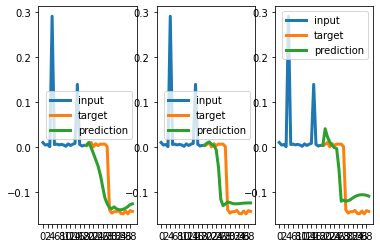

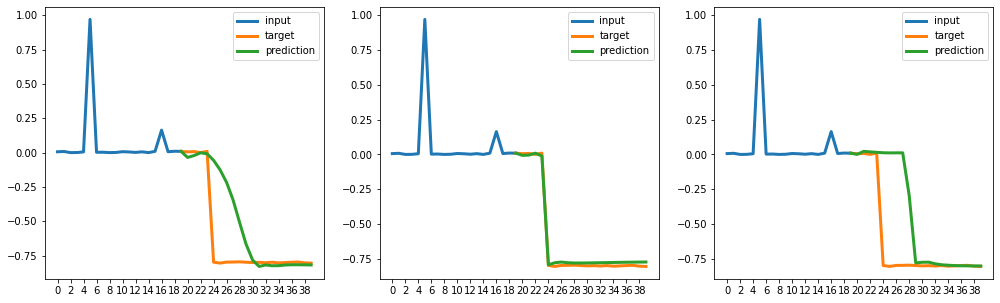

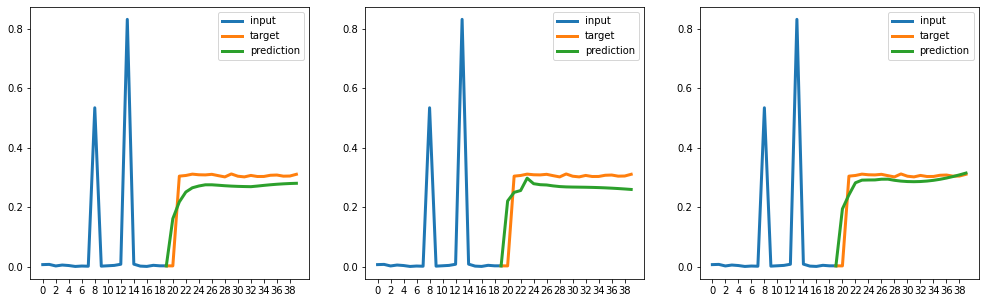

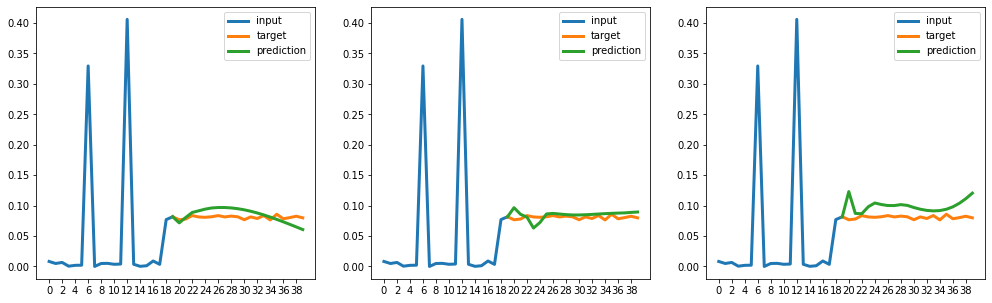

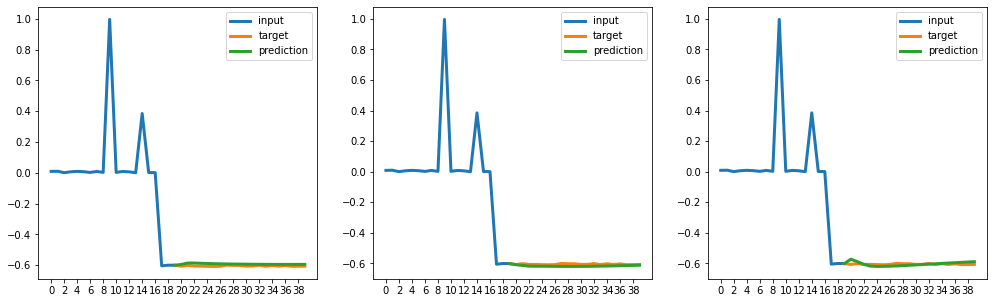

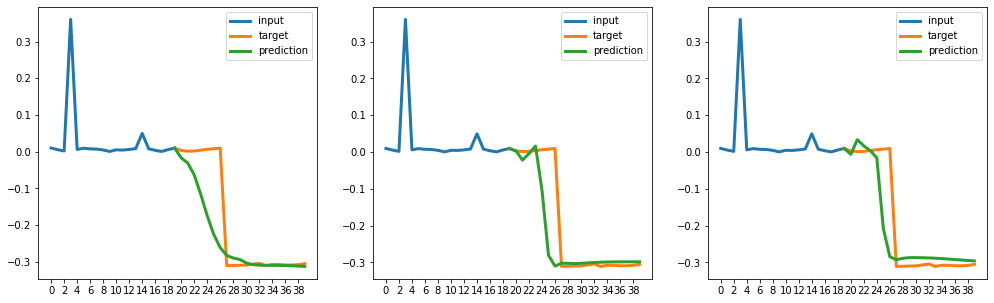

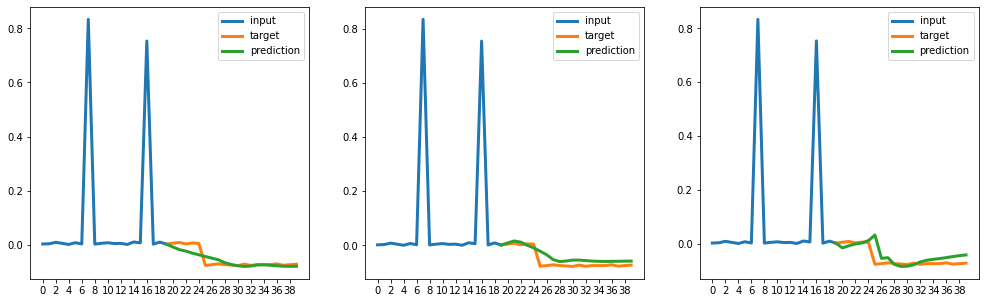

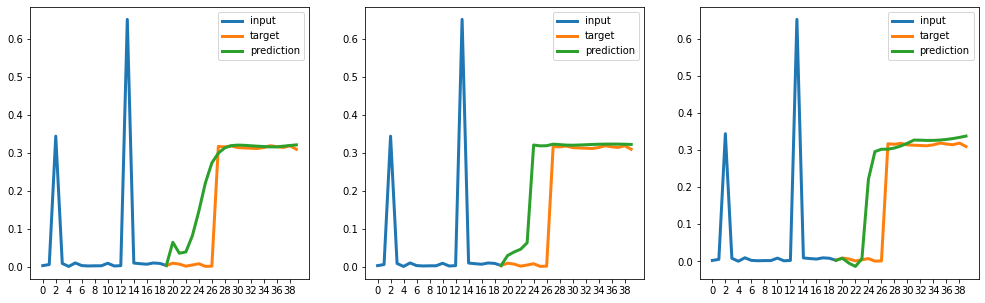

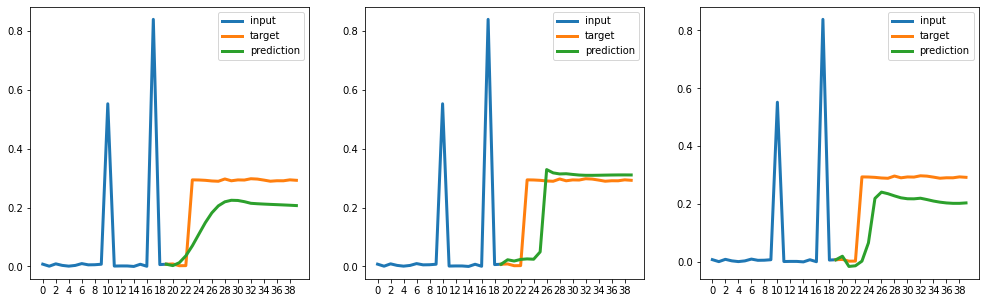

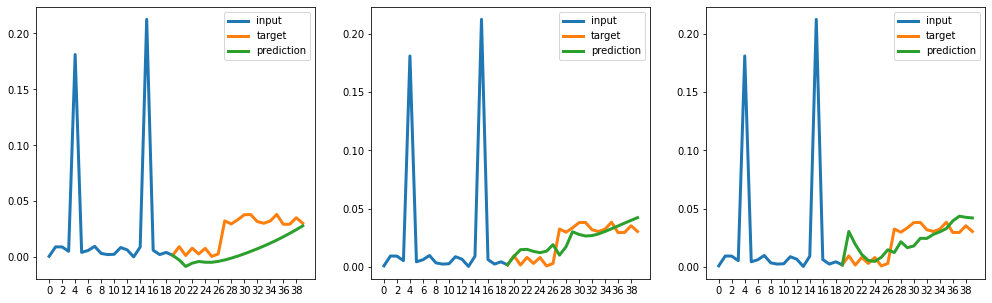

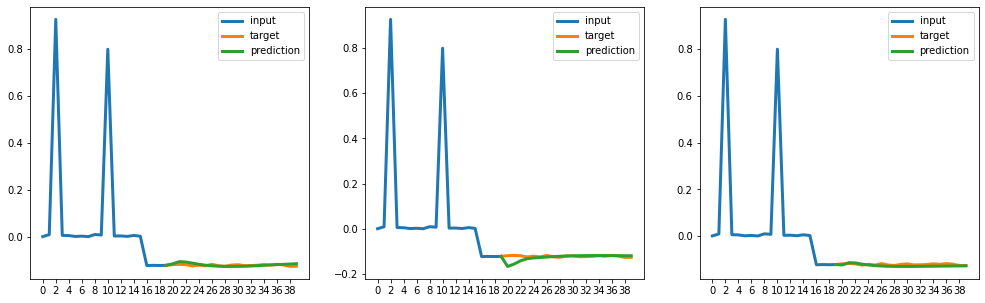

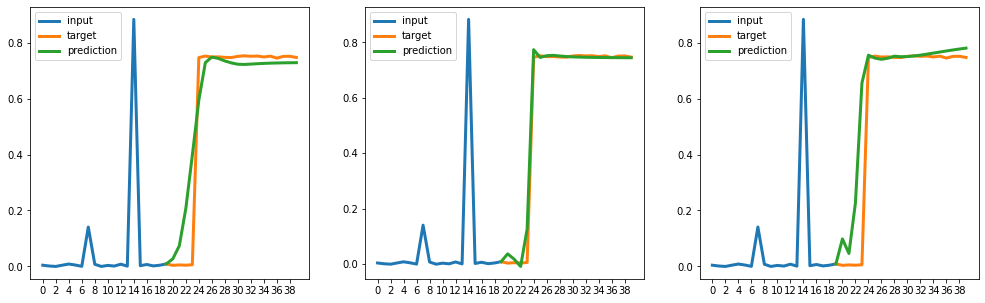

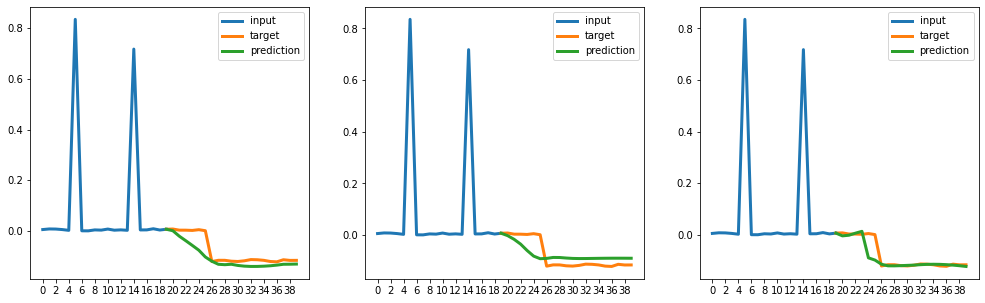

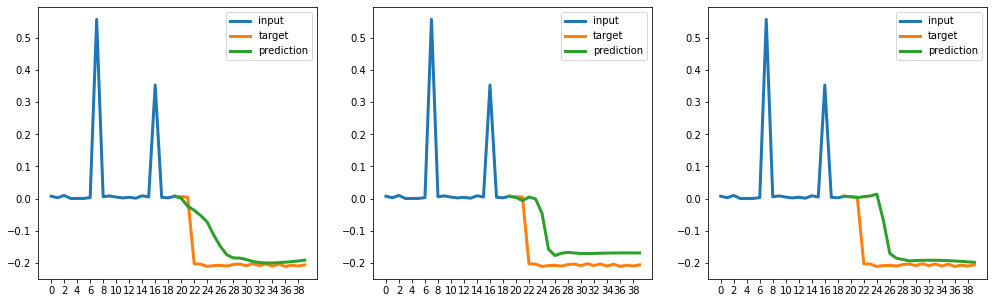

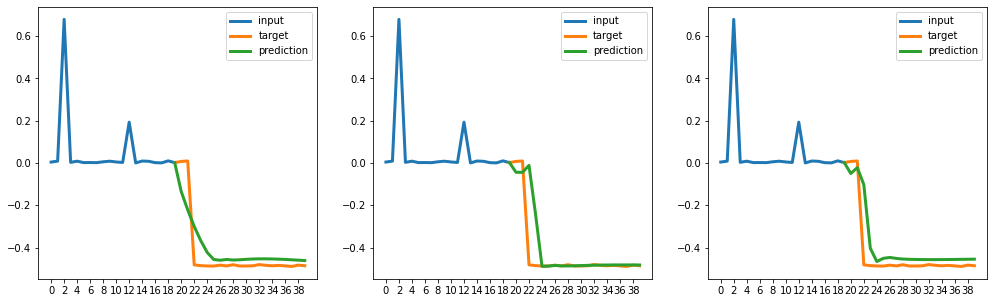

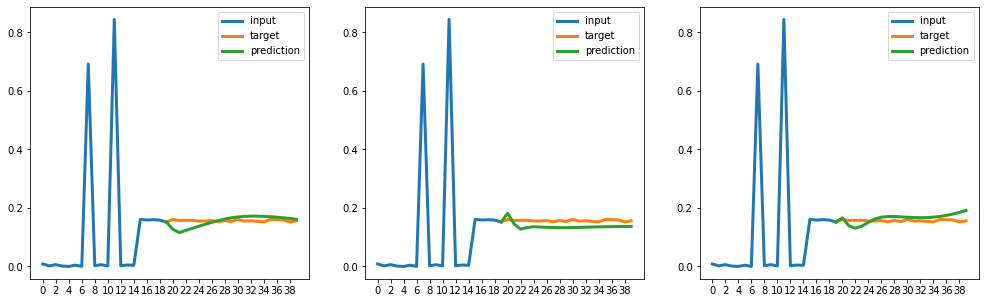

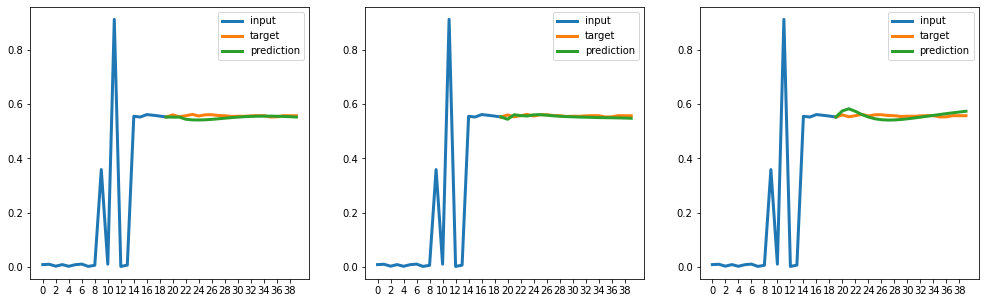

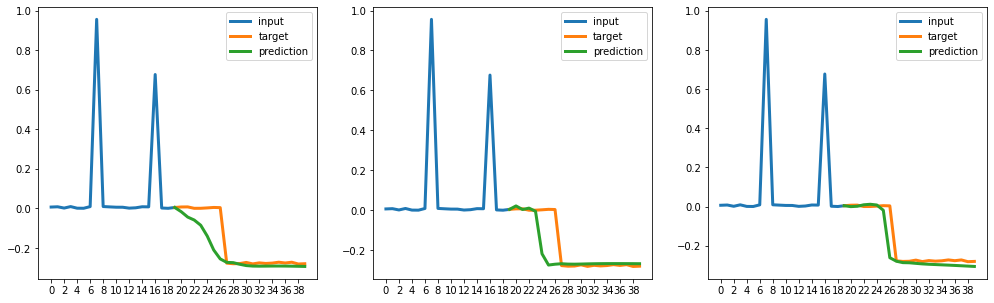

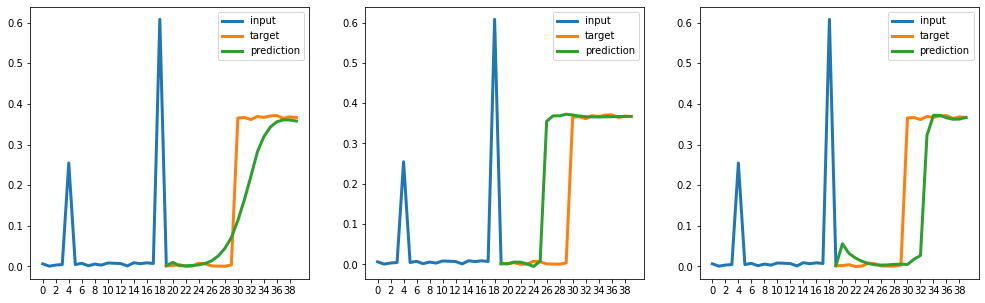

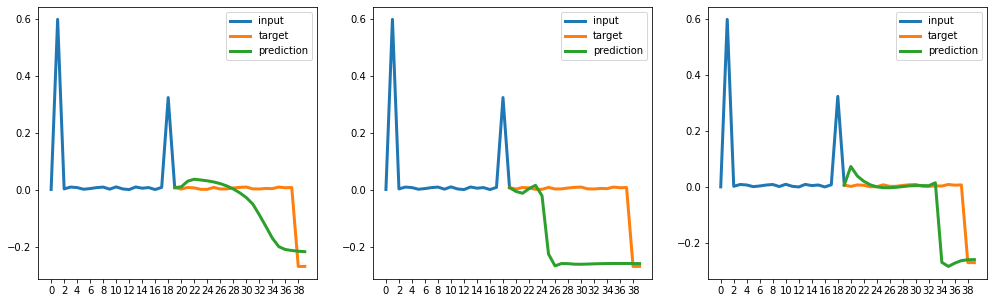

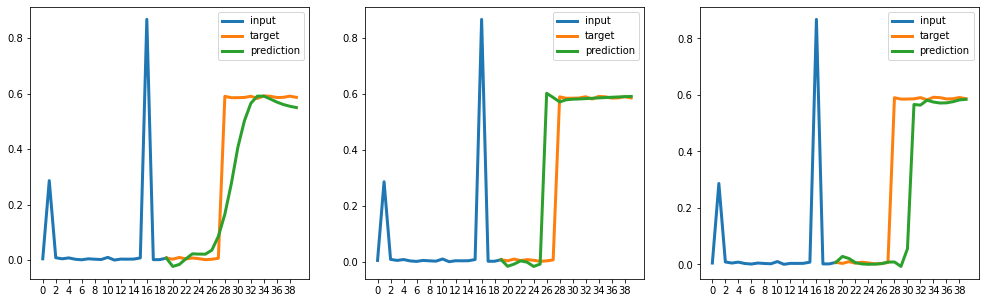

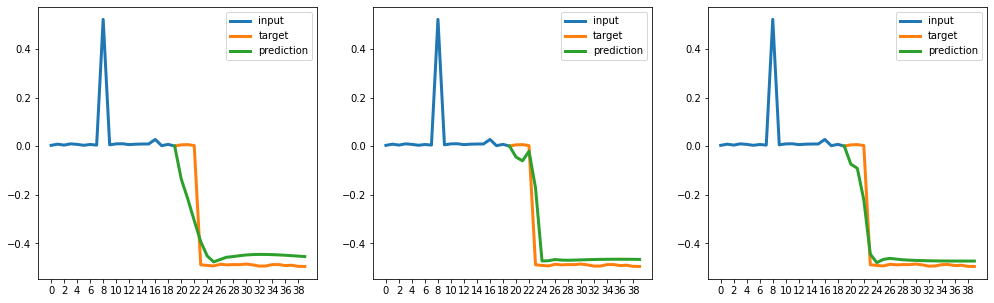

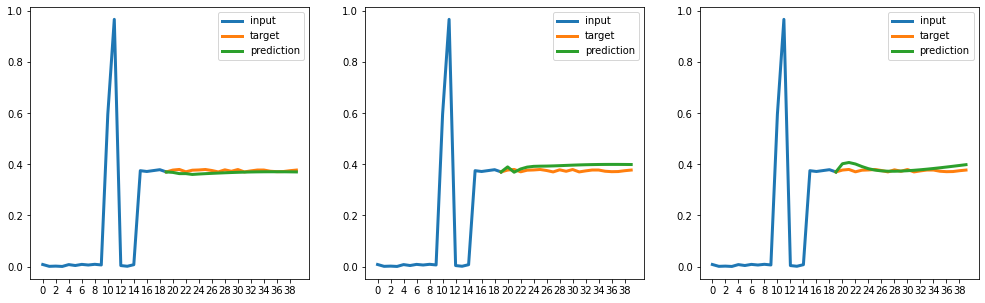

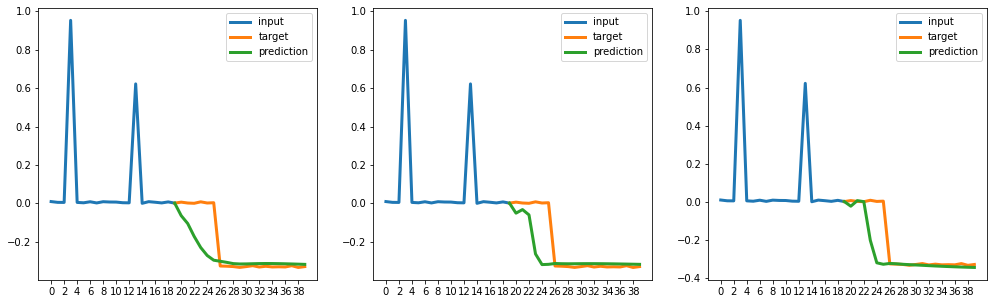

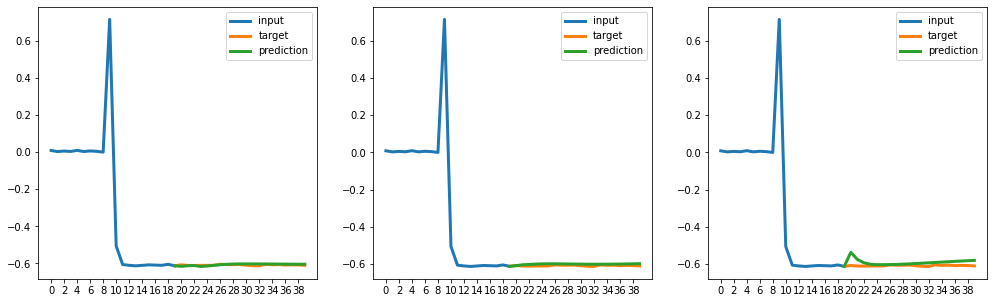

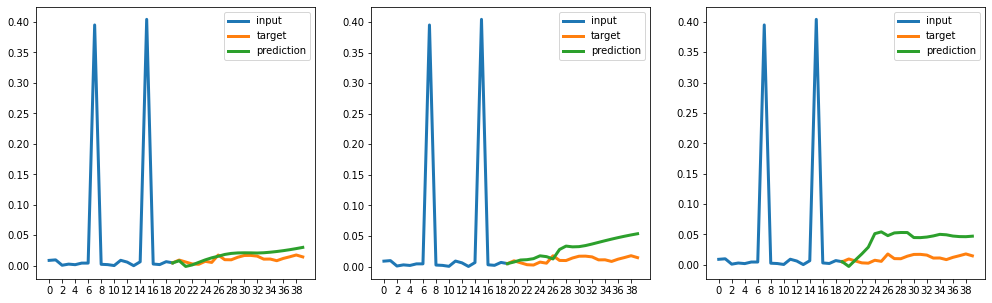

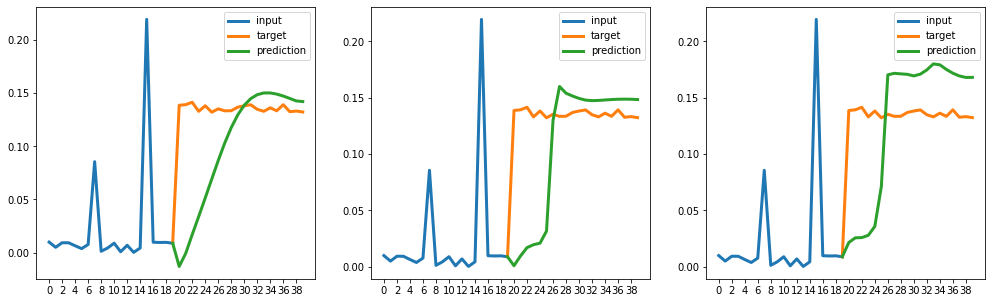

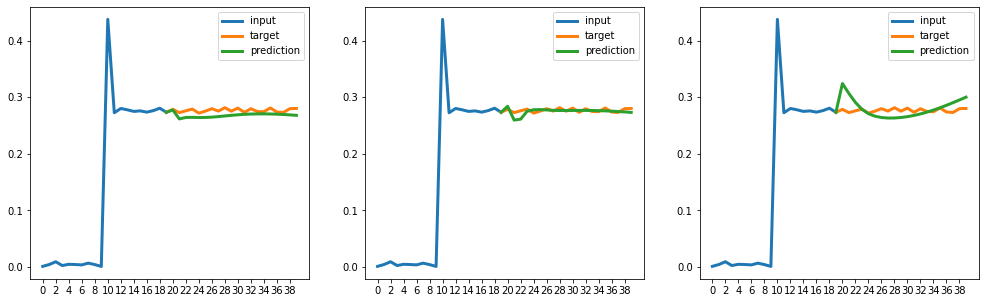

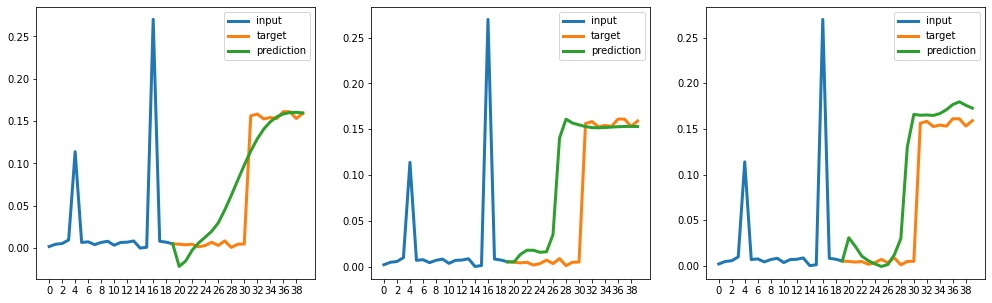

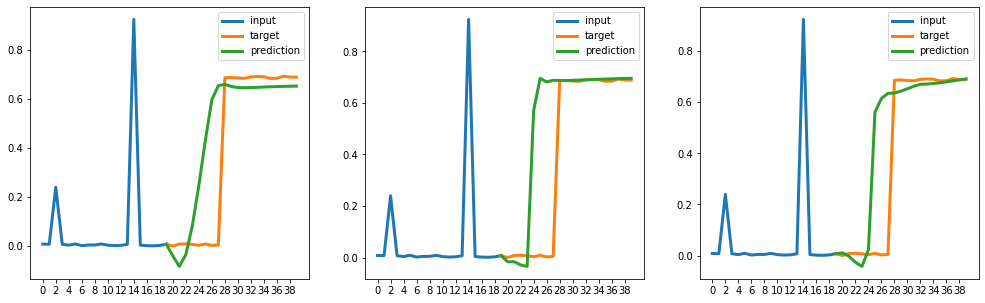

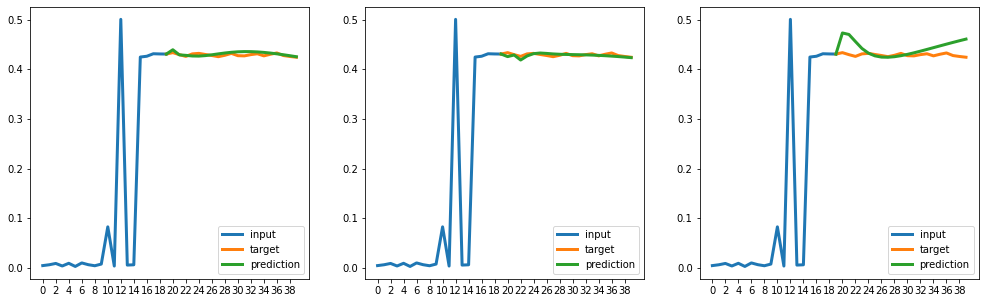

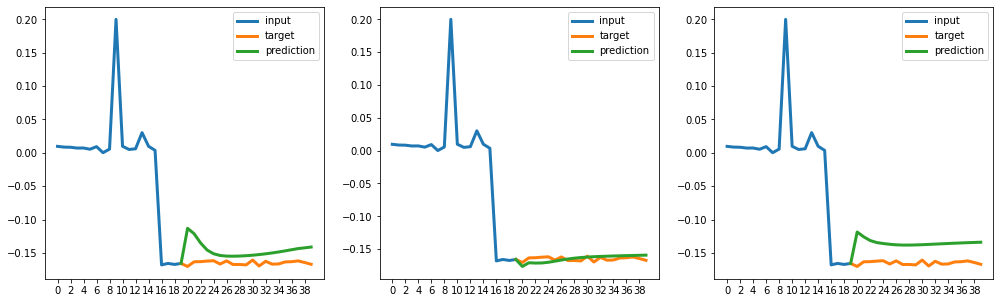

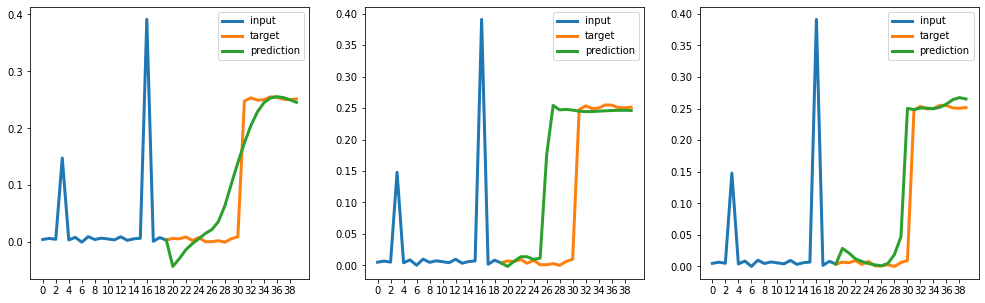

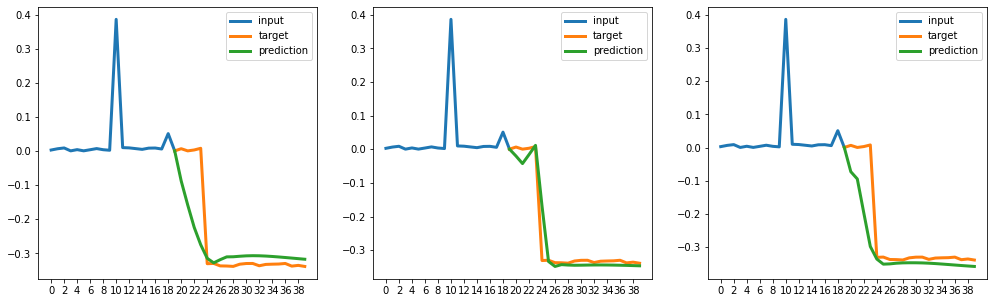

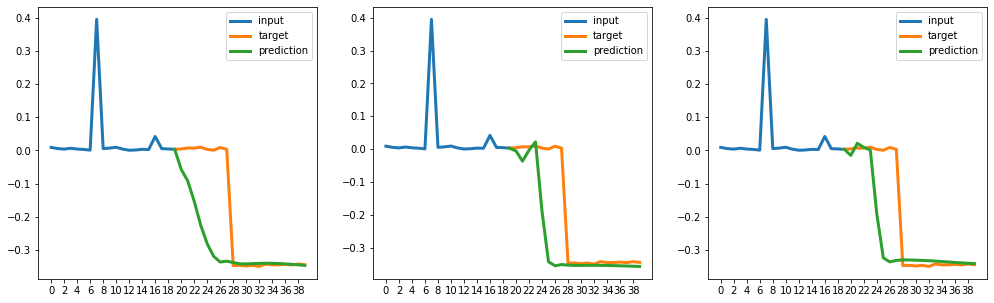

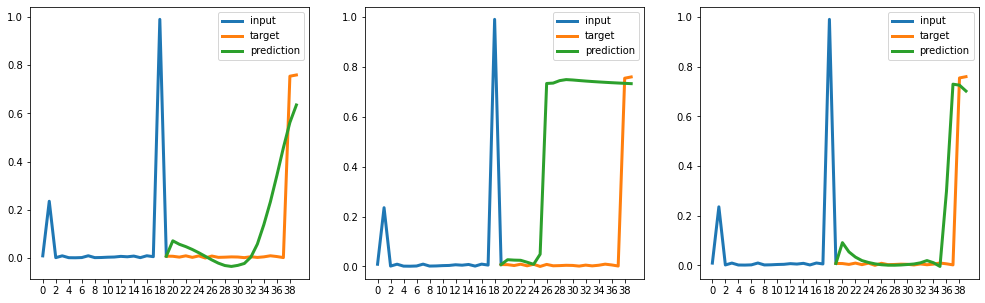

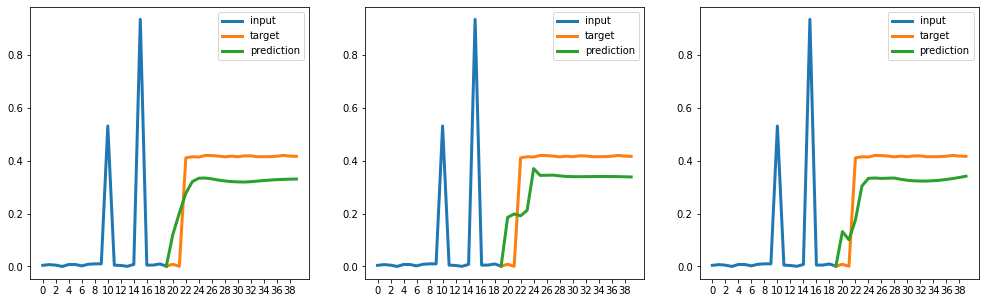

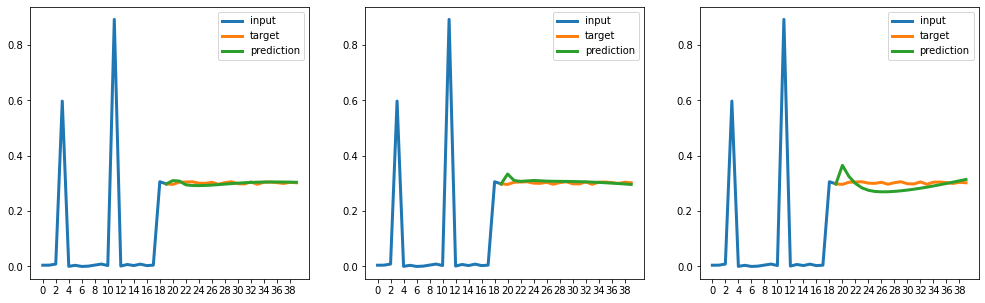

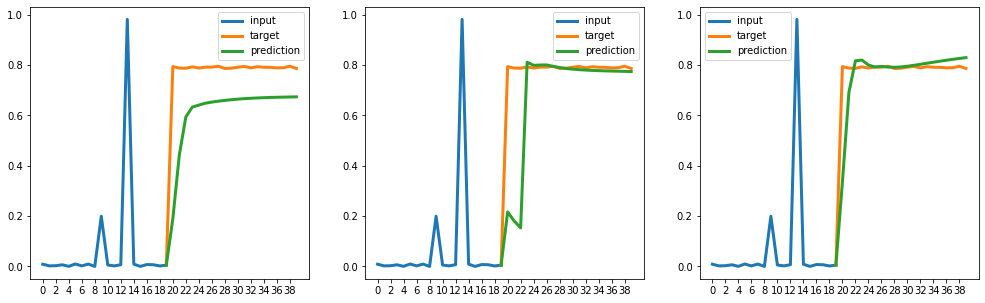

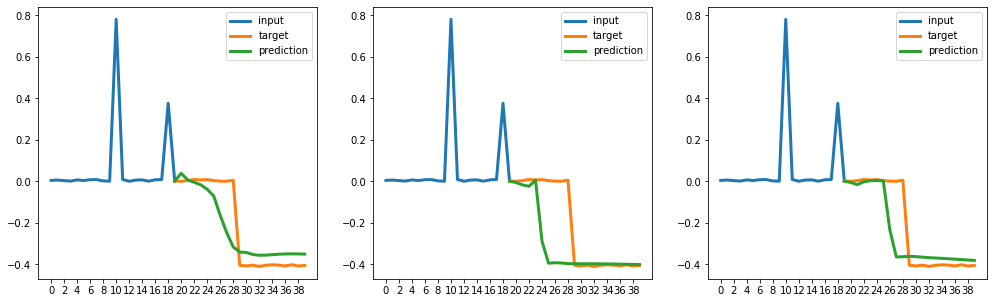

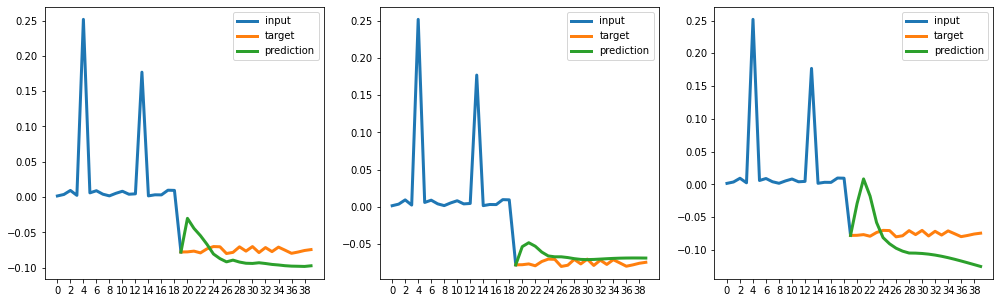

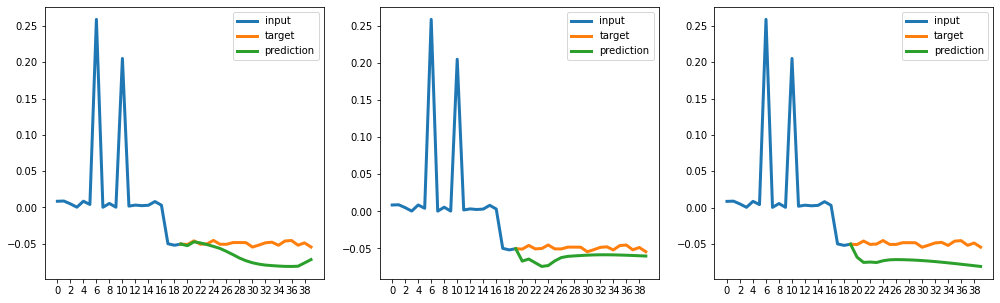

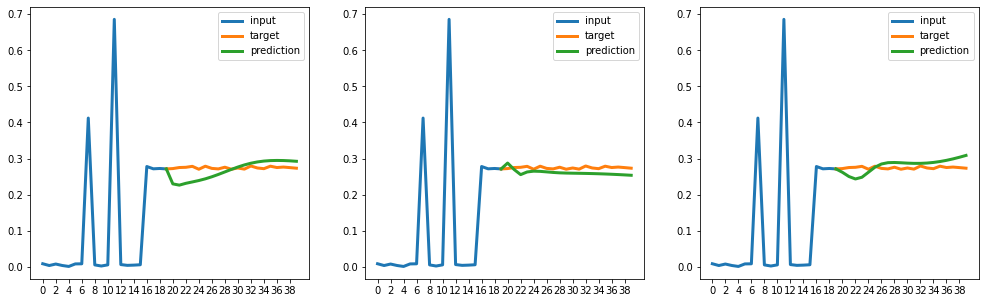

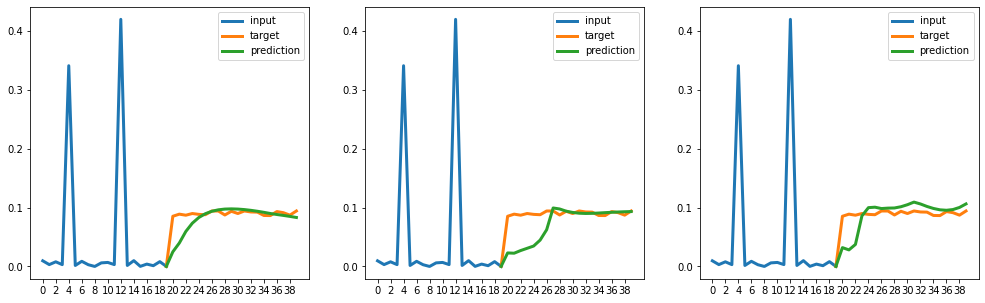

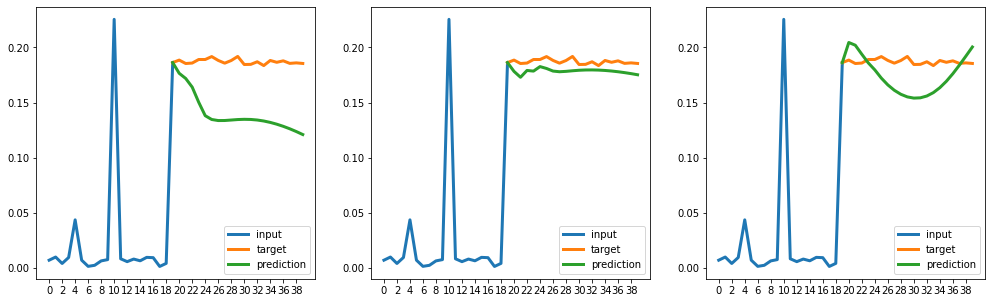

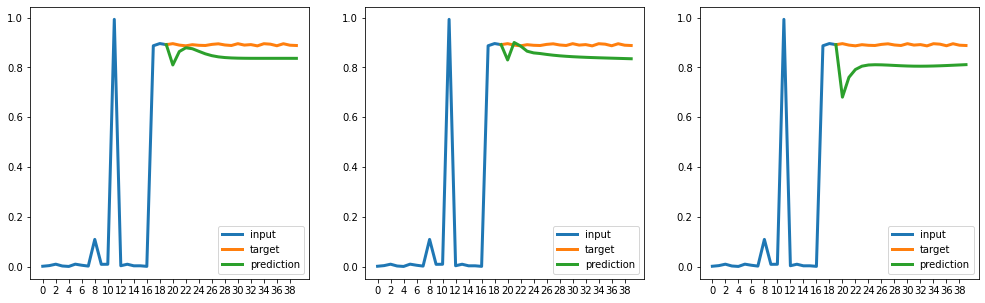

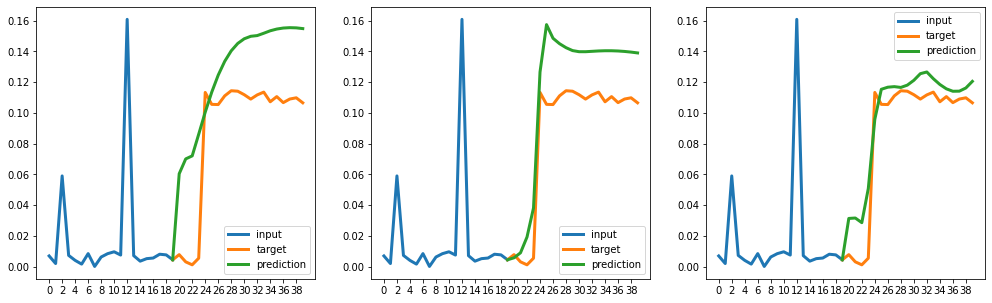

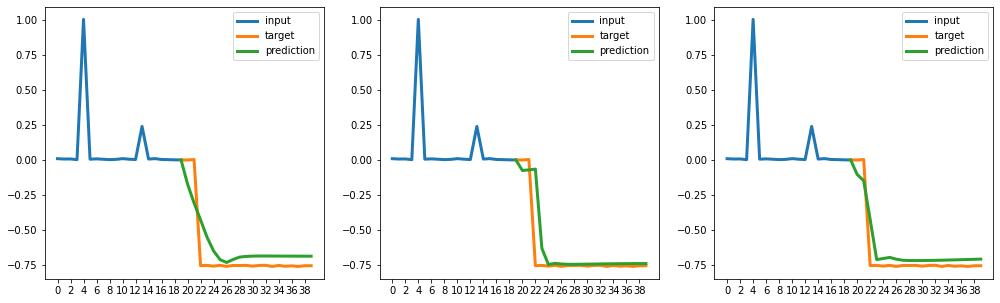

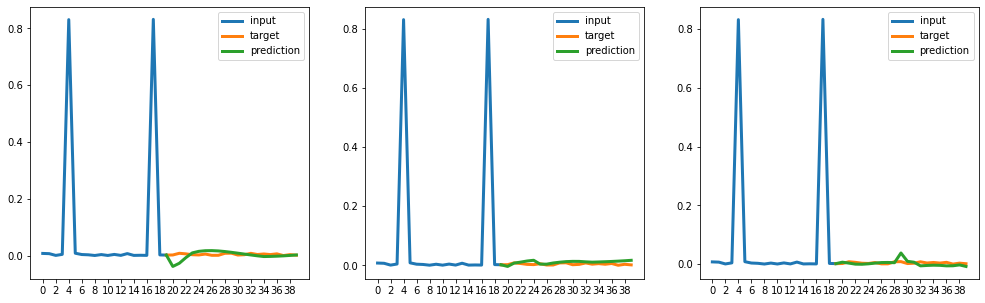

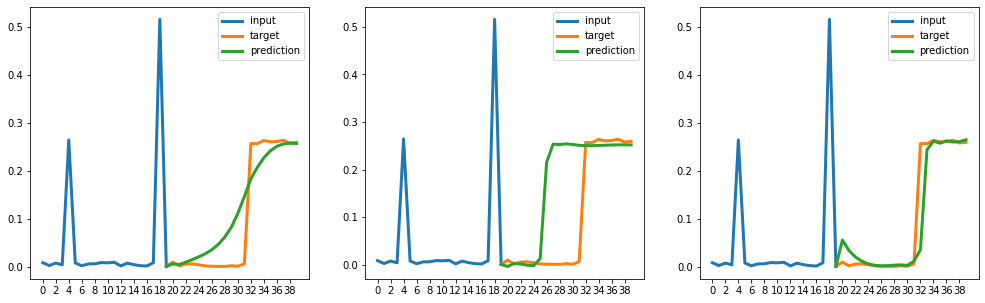

In [0]:
# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse, net_gru_dtw, net_gru_dilate]

for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)   
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,40,2))
        plt.legend()
        k = k+1

    plt.show()


# Using Traffic Dataset


In [0]:
from google.colab import files
uploaded = files.upload()

Saving fd_shape.tsv to fd_shape (2).tsv


In [0]:
import pandas as pd
import io

#tsk = pd.read_csv(io.BytesIO(uploaded['fd_shape.tsv']), sep='\t')
def obtain_traffic_dataset(tsv_filename,no_in,no_out):
  # no_in: import of time steps in input series
  # no_out: import of time steps in output series
  # sigma: standard deviation of additional noise
  content = pd.read_csv(io.BytesIO(uploaded[tsv_filename]), sep='\t')
  occ = []
  data = content.to_numpy()[:80000,1]
  occ = data.reshape(1000,80)
  return occ[0:500,0:no_in], occ[0:500,no_in:no_in+no_out], occ[500:1000,0:no_in], occ[500:1000,no_in:no_in+no_out]

class TrafficDataset(torch.utils.data.Dataset):
  def __init__(self,occ_input,occu_target):
    super(TrafficDataset,self).__init__()
    self.occ_input=occ_input
    self.occu_target=occu_target
  
  def __len__(self):
    return (self.occ_input).shape[0]
    
  def __getitem__(self, idx):
    return (self.occ_input[idx,:,np.newaxis], self.occu_target[idx,:,np.newaxis])
    

In [0]:
InputNo=50
OutputNo=30
sigma = 0.01
gamma = 0.01
batch_size = 100
N = 500

# Load traffic dataset
traffic_train_input,traffic_train_target,traffic_test_input,traffic_test_target = obtain_traffic_dataset('fd_shape.tsv',InputNo,OutputNo)
trafficDataset_train = TrafficDataset(traffic_train_input,traffic_train_target)
trafficDataset_test  = TrafficDataset(traffic_test_input,traffic_test_target)
trafficTrainloader = DataLoader(trafficDataset_train, batch_size=100,shuffle=True, num_workers=1)
trafficTestloader  = DataLoader(trafficDataset_test, batch_size=100,shuffle=False, num_workers=1)

In [0]:
def trainTraffic_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.8):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(trafficTrainloader, 0):
            traffic_input, traffic_target = data
            traffic_input = torch.tensor(traffic_input, dtype=torch.float32).to(device)
            traffic_target = torch.tensor(traffic_target, dtype=torch.float32).to(device)
            batch_size, OutputNo = traffic_target.shape[0:2]                     

            # forward + backward + optimize
            traffic_outputs = net(traffic_input)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(traffic_target,traffic_outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(traffic_target,traffic_outputs,alpha, gamma, device)             

            if (loss_type=='DTW'):    
                loss, loss_shape, loss_temporal = dilate_loss(traffic_target,traffic_outputs,alpha, gamma, device)     
                loss = loss_shape    

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        
        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                evalTraffic_model(net,trafficTestloader, gamma,verbose=1)

In [0]:
def evalTraffic_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        traffic_input, traffic_target = data
        traffic_input = torch.tensor(traffic_input, dtype=torch.float32).to(device)
        traffic_target = torch.tensor(traffic_target, dtype=torch.float32).to(device)
        batch_size, OutputNo = traffic_target.shape[0:2]
        traffic_outputs = net(traffic_input)
         
        # MSE    
        loss_mse = criterion(traffic_target,traffic_outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = traffic_target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = traffic_outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            loss_dtw += dtw(target_k_cpu,output_k_cpu)
            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (OutputNo*OutputNo)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 

In [0]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate_2 = Net_GRU(encoder,decoder, OutputNo, device).to(device)
trainTraffic_model(net_gru_dilate_2,loss_type='dilate',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch  0  loss  5.358669757843018  loss shape  6.664064884185791  loss temporal  0.13708743453025818
 Eval mse=  0.22624973058700562  dtw=  2.5109236290125803  tdi=  0.0
epoch  50  loss  1.186320185661316  loss shape  1.298797845840454  loss temporal  0.7364095449447632
 Eval mse=  0.06007867678999901  dtw=  1.2379044643540715  tdi=  1.1568266666666662
epoch  100  loss  0.945643424987793  loss shape  0.7285957336425781  loss temporal  1.8138338327407837
 Eval mse=  0.0649739757180214  dtw=  0.9352752235202363  tdi=  1.9764377777777782
epoch  150  loss  0.6109024286270142  loss shape  0.4463390111923218  loss temporal  1.2691560983657837
 Eval mse=  0.06825153753161431  dtw=  0.7803387583490415  tdi=  1.4966177777777783
epoch  200  loss  0.5439472198486328  loss shape  0.407539427280426  loss temporal  1.08957839012146
 Eval mse=  0.07191217690706253  dtw=  0.7555848286505806  tdi=  1.3072533333333334
epoch  250  loss  0.4840768575668335  loss shape  0.41414332389831543  loss temporal  

In [0]:
evalTraffic_model(net_gru_dilate_2,trafficTestloader, gamma,verbose=1)

 Eval mse=  0.07391345649957656  dtw=  0.7507148781514987  tdi=  1.080162222222222


In [0]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dtw_2 = Net_GRU(encoder,decoder, OutputNo, device).to(device)
trainTraffic_model(net_gru_dtw_2,loss_type='DTW',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch  0  loss  5.952621936798096  loss shape  5.952621936798096  loss temporal  0.32444268465042114
 Eval mse=  0.2035829246044159  dtw=  2.3722400058420647  tdi=  0.0
epoch  50  loss  0.9961205124855042  loss shape  0.9961205124855042  loss temporal  3.8626410961151123
 Eval mse=  0.06932950019836426  dtw=  0.997792525890041  tdi=  4.204217777777778
epoch  100  loss  0.39215269684791565  loss shape  0.39215269684791565  loss temporal  4.35115385055542
 Eval mse=  0.087857086956501  dtw=  0.7734991422850832  tdi=  5.264115555555554
epoch  150  loss  0.6190903186798096  loss shape  0.6190903186798096  loss temporal  5.49640417098999
 Eval mse=  0.08210931420326233  dtw=  0.7502659794722296  tdi=  5.624484444444443
epoch  200  loss  0.46577125787734985  loss shape  0.46577125787734985  loss temporal  5.456744194030762
 Eval mse=  0.0843363344669342  dtw=  0.7535740153705197  tdi=  5.700633333333335
epoch  250  loss  0.4497893154621124  loss shape  0.4497893154621124  loss temporal  4.68

In [0]:
evalTraffic_model(net_gru_dtw_2,trafficTestloader, gamma,verbose=1)

 Eval mse=  0.08803515285253524  dtw=  0.8619111664571122  tdi=  5.194451111111112


In [0]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse_2 = Net_GRU(encoder,decoder, OutputNo, device).to(device)
trainTraffic_model(net_gru_mse_2,loss_type='mse',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch  0  loss  0.3158343434333801  loss shape  0  loss temporal  0
 Eval mse=  0.32136903405189515  dtw=  3.0256924476259233  tdi=  0.0
epoch  50  loss  0.06004177778959274  loss shape  0  loss temporal  0
 Eval mse=  0.05918096080422401  dtw=  1.1616892016665237  tdi=  3.3048199999999994
epoch  100  loss  0.048172727227211  loss shape  0  loss temporal  0
 Eval mse=  0.0535545788705349  dtw=  1.0628530676643748  tdi=  2.4425
epoch  150  loss  0.041628673672676086  loss shape  0  loss temporal  0
 Eval mse=  0.04798101484775543  dtw=  1.004034823692924  tdi=  1.8243244444444442
epoch  200  loss  0.03680488094687462  loss shape  0  loss temporal  0
 Eval mse=  0.04759391844272613  dtw=  0.9950324134284715  tdi=  1.8938644444444441
epoch  250  loss  0.042979225516319275  loss shape  0  loss temporal  0
 Eval mse=  0.049665533006191254  dtw=  0.9627008924787939  tdi=  1.9678577777777775
epoch  300  loss  0.038058649748563766  loss shape  0  loss temporal  0
 Eval mse=  0.0474388316273689

In [0]:
evalTraffic_model(net_gru_mse_2,trafficTestloader, gamma,verbose=1)

 Eval mse=  0.05422653257846832  dtw=  0.9332189827592128  tdi=  1.6243288888888887


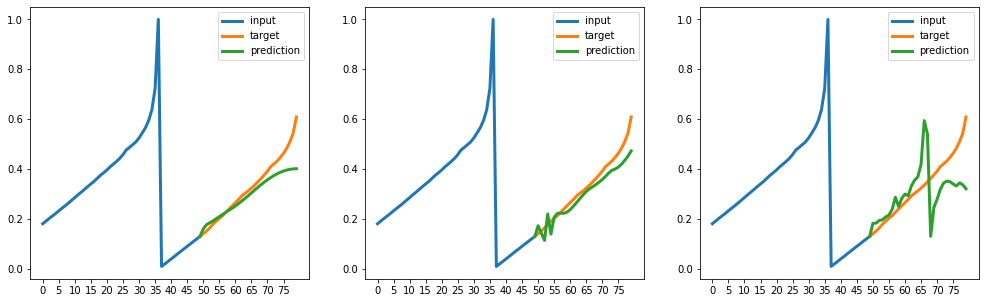

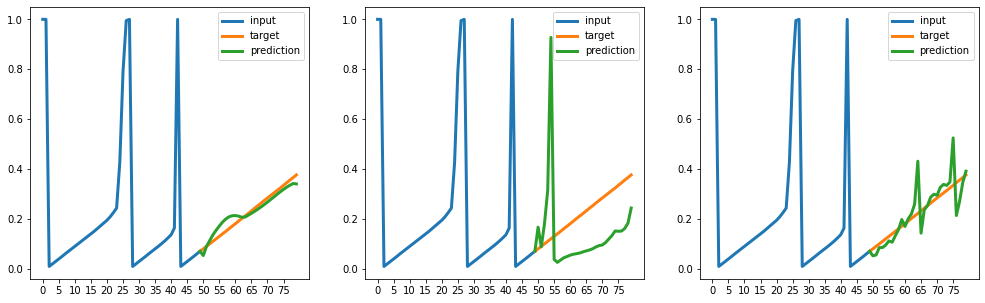

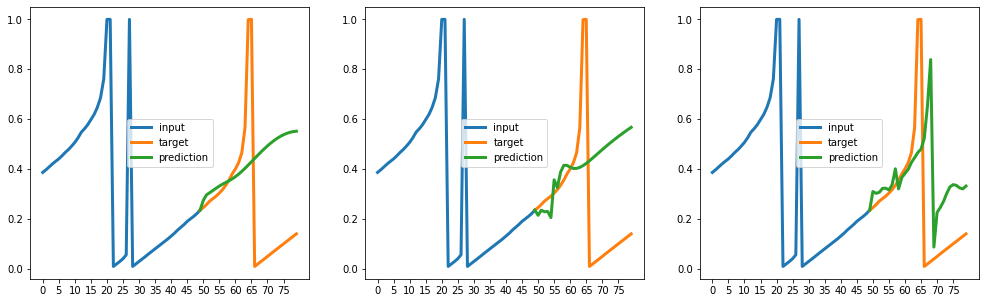

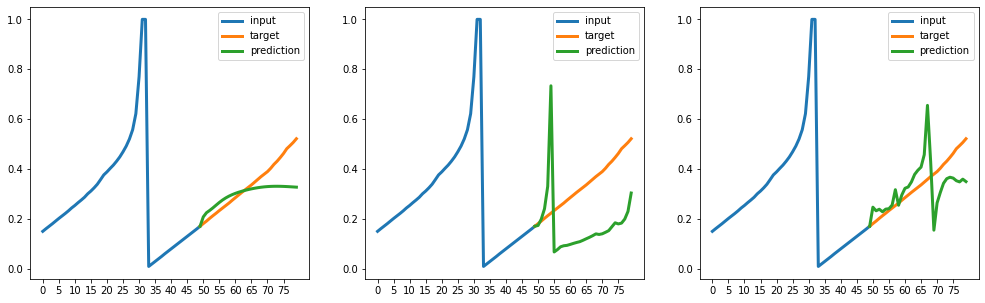

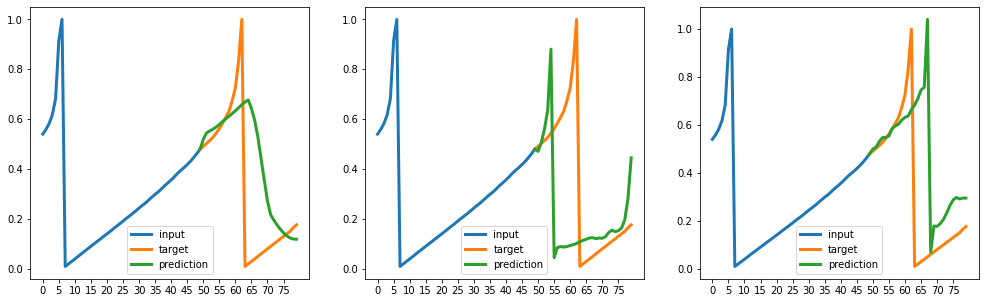

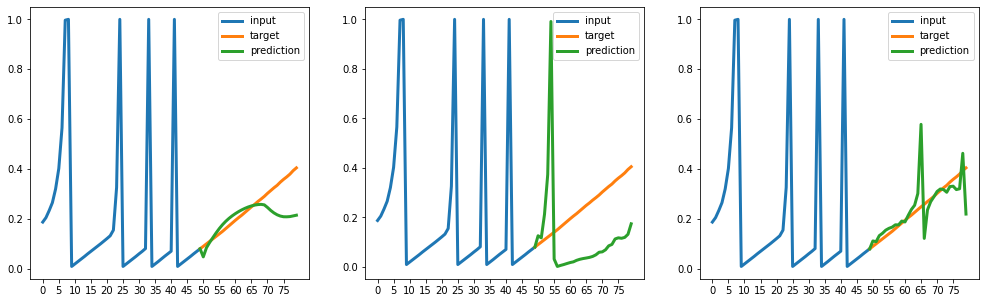

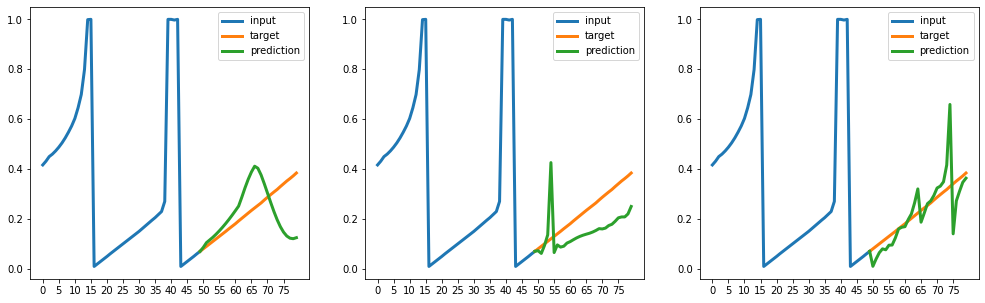

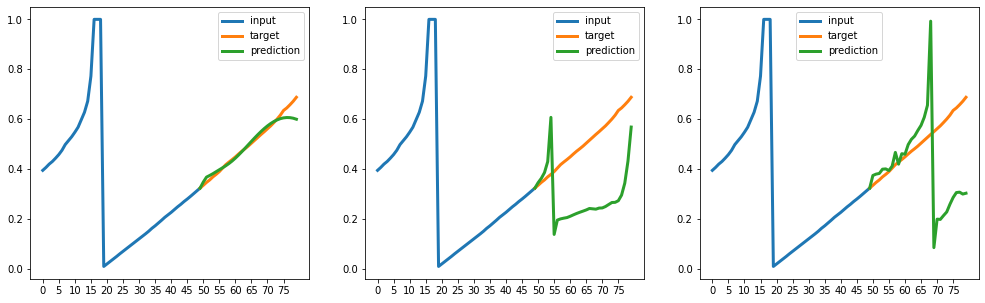

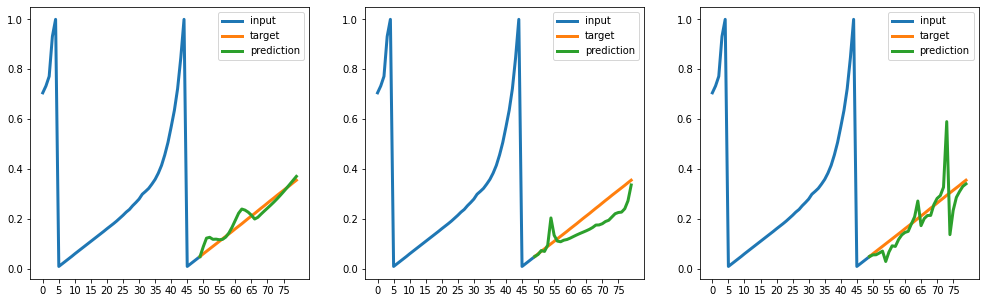

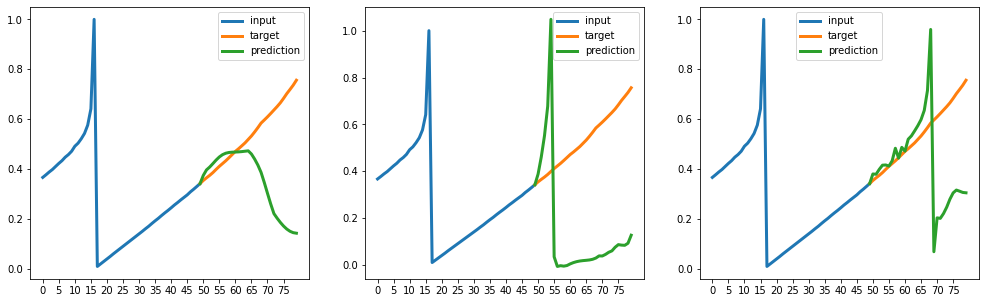

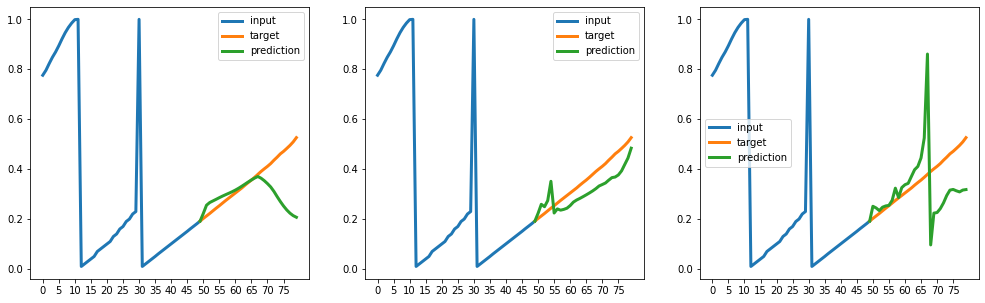

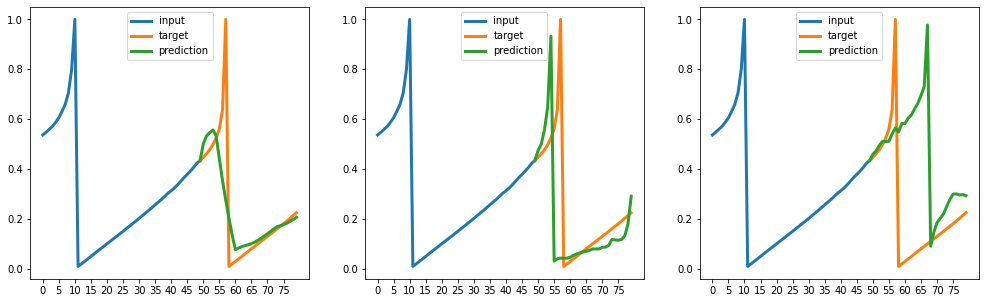

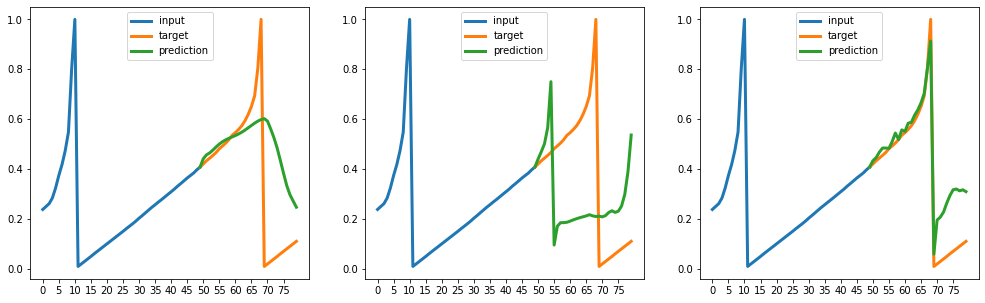

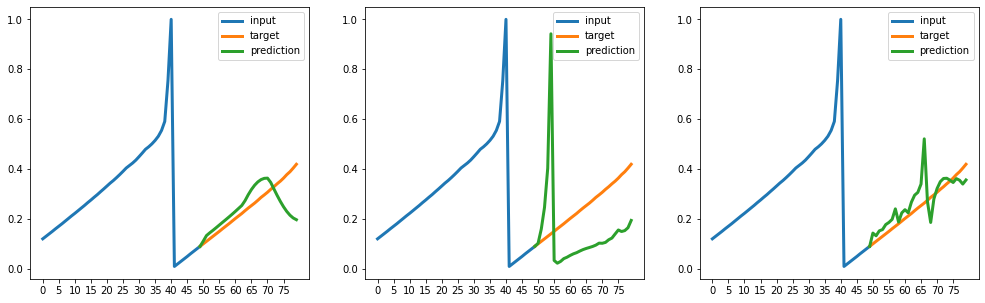

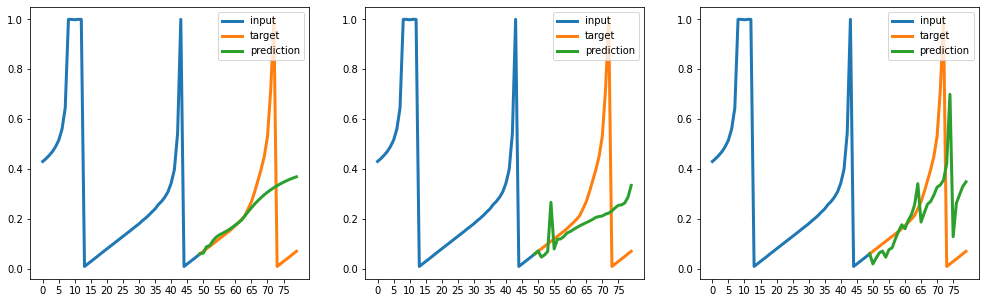

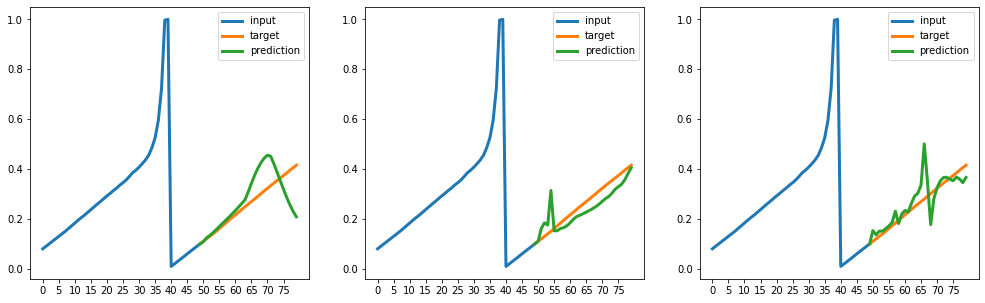

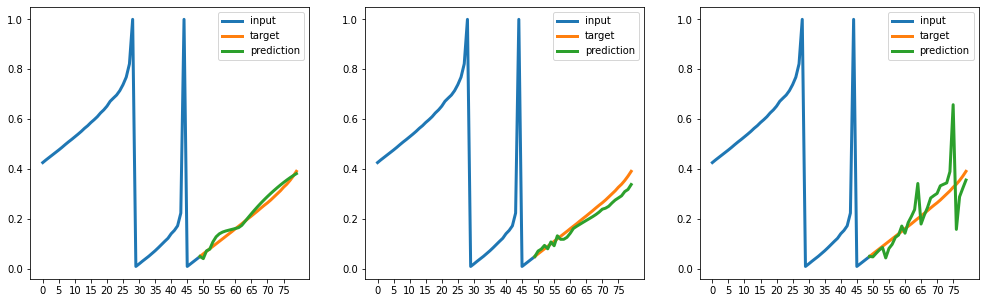

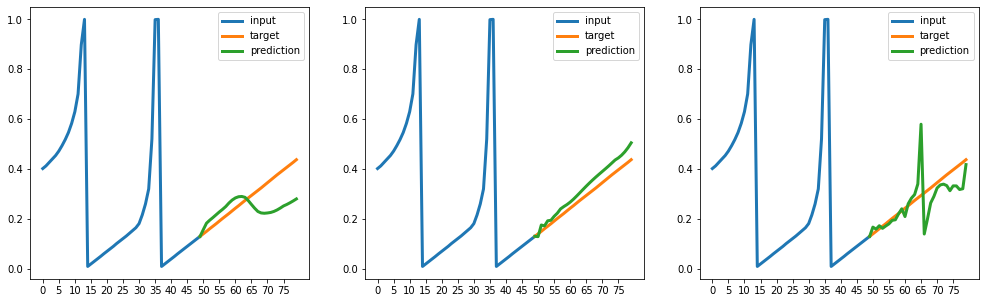

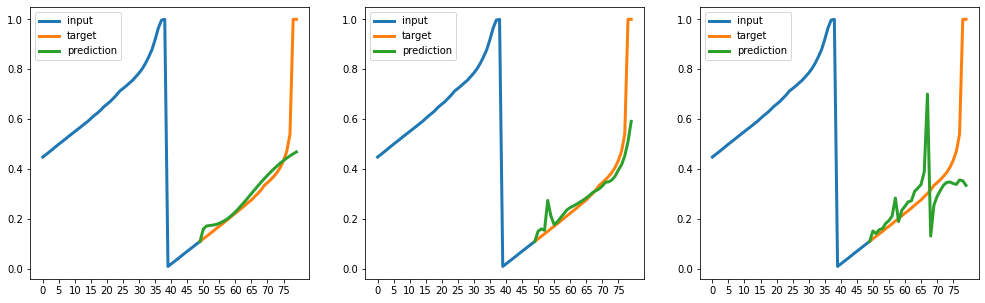

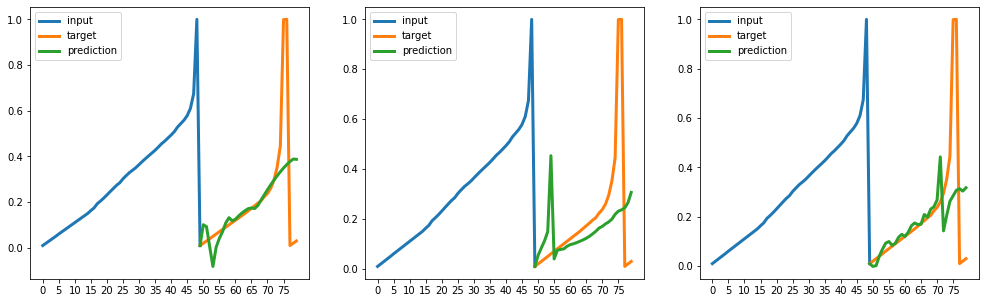

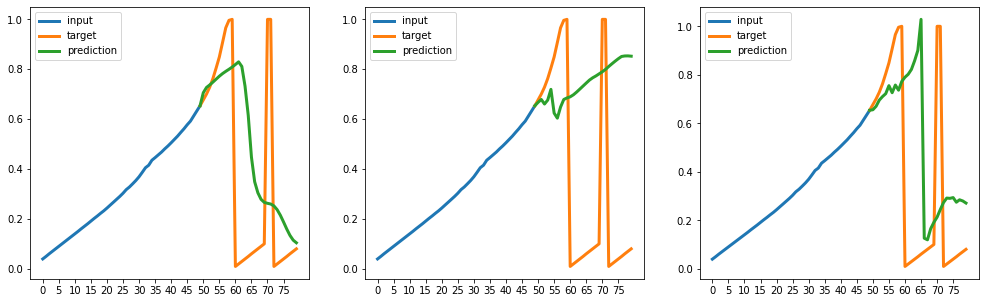

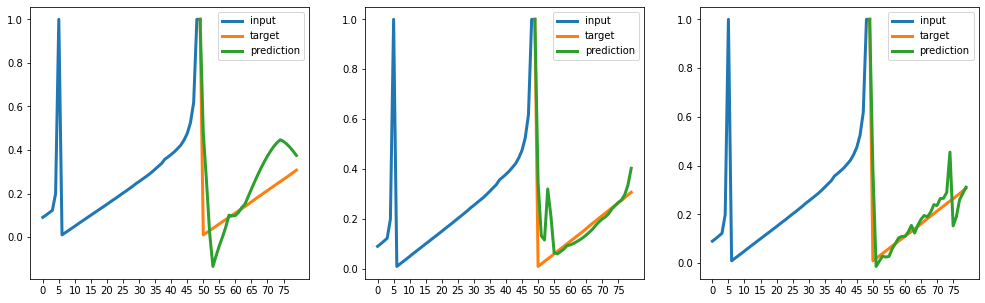

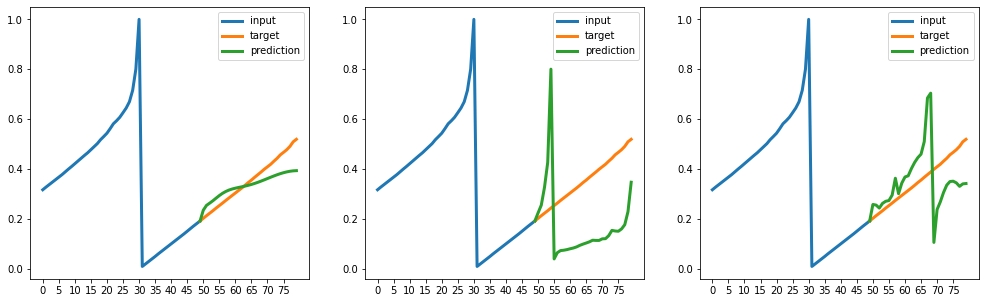

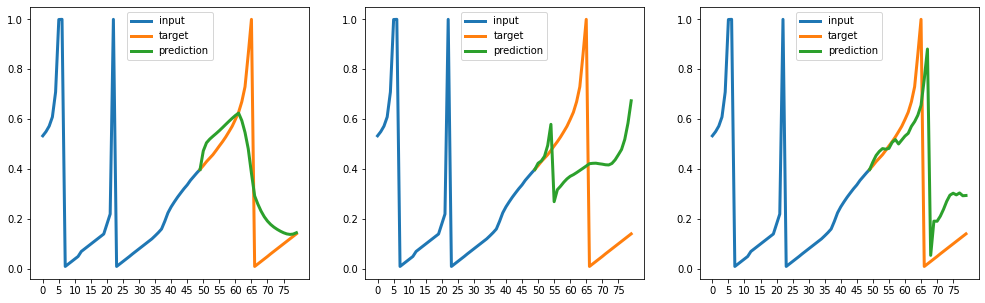

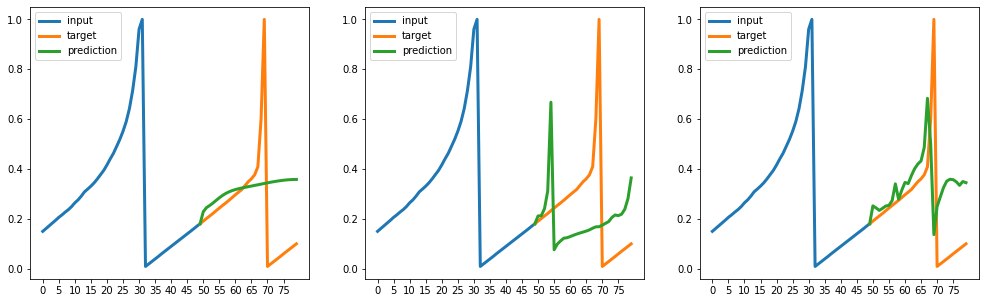

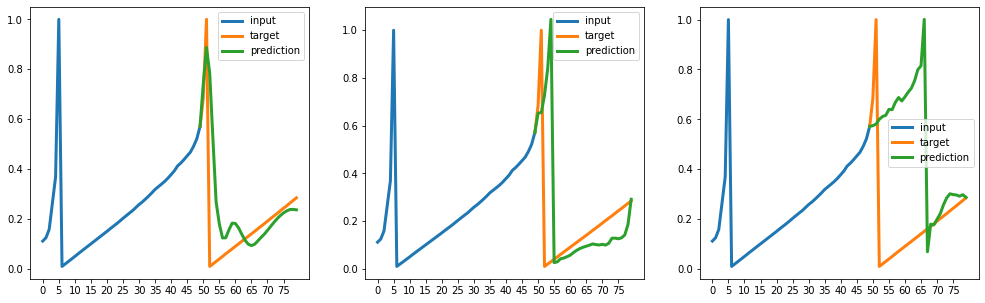

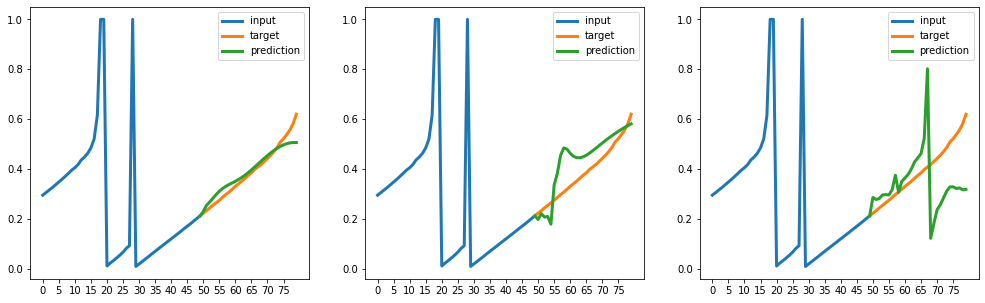

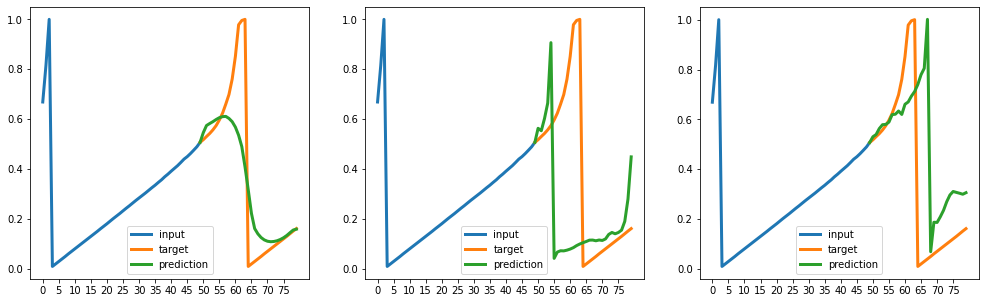

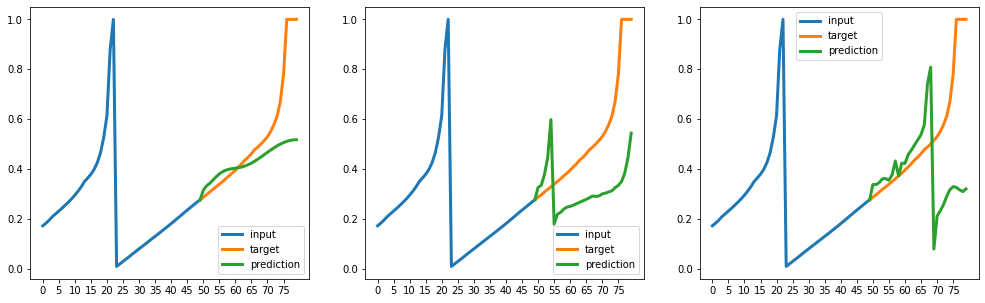

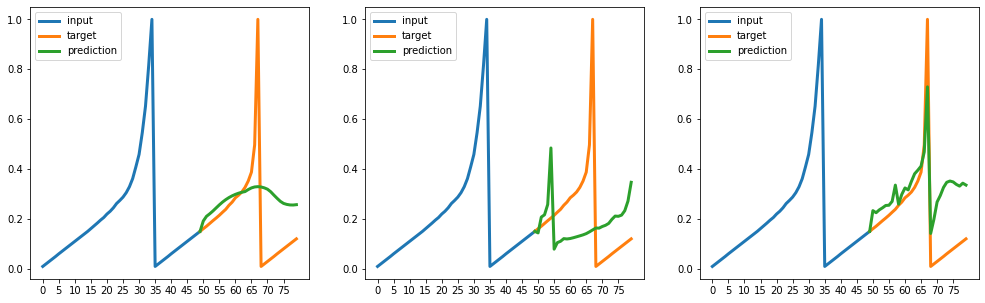

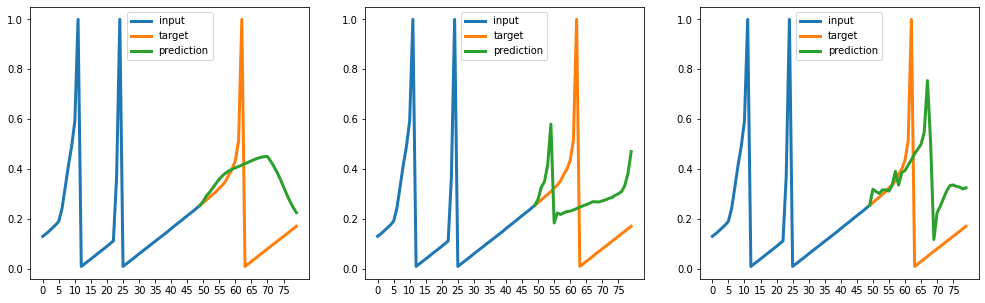

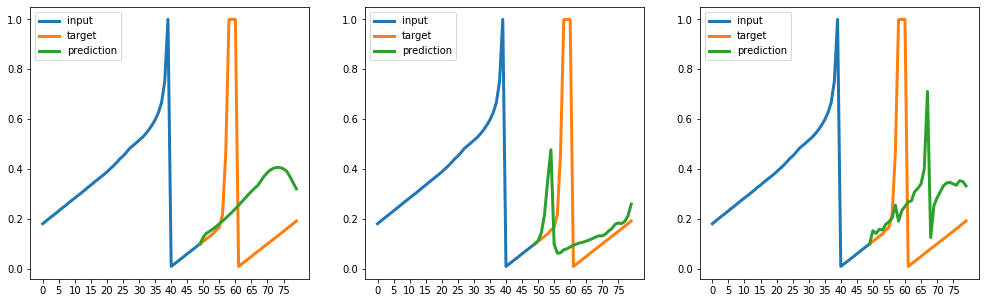

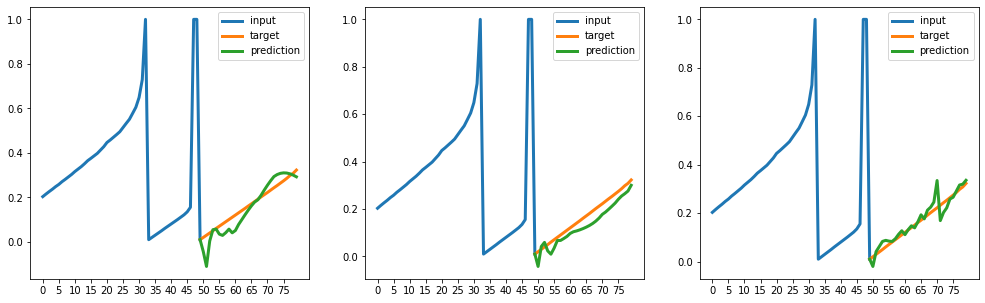

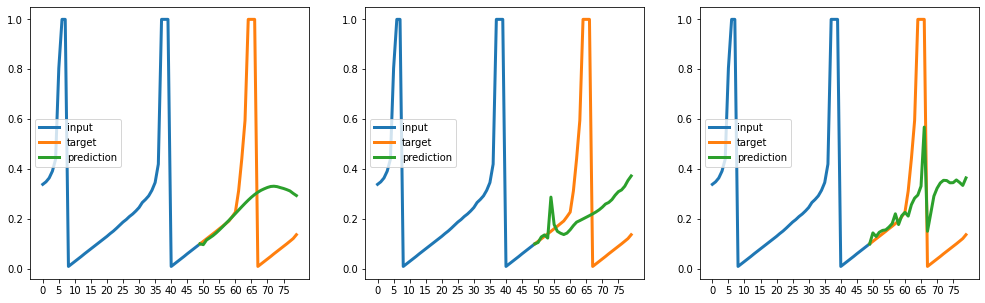

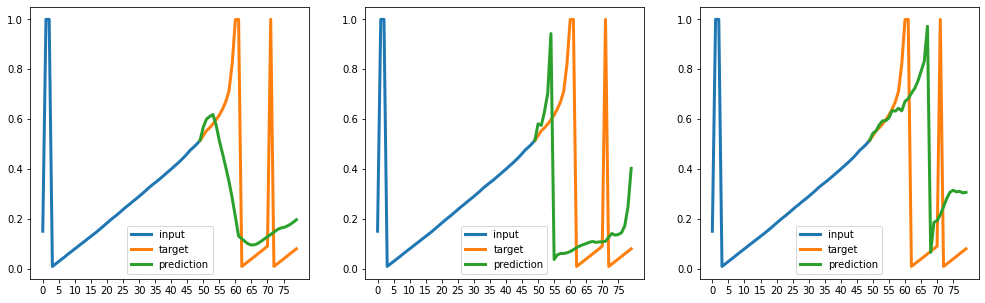

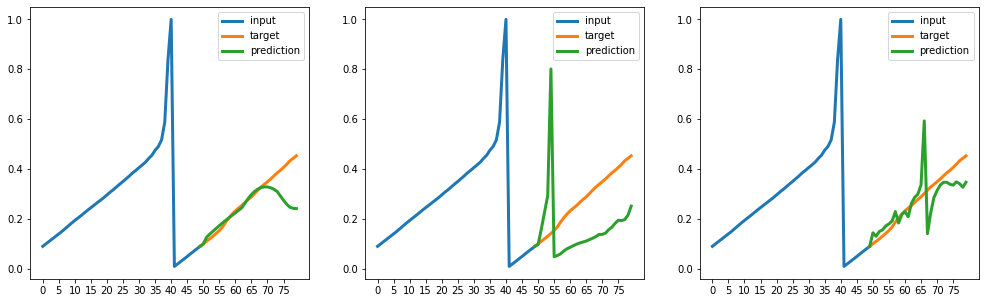

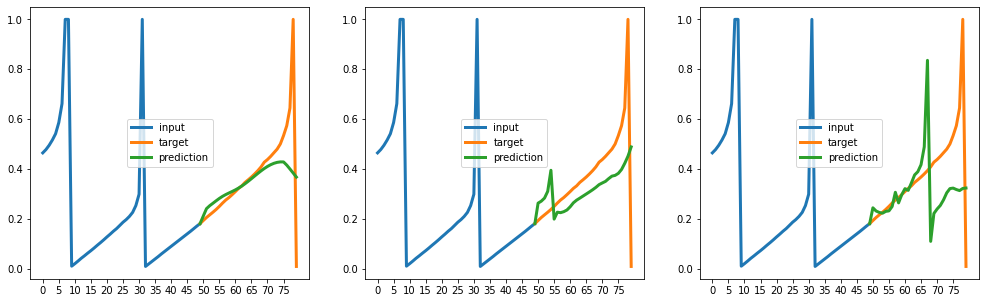

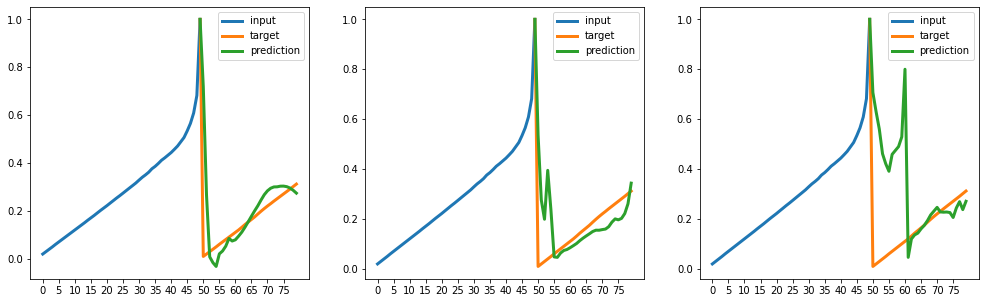

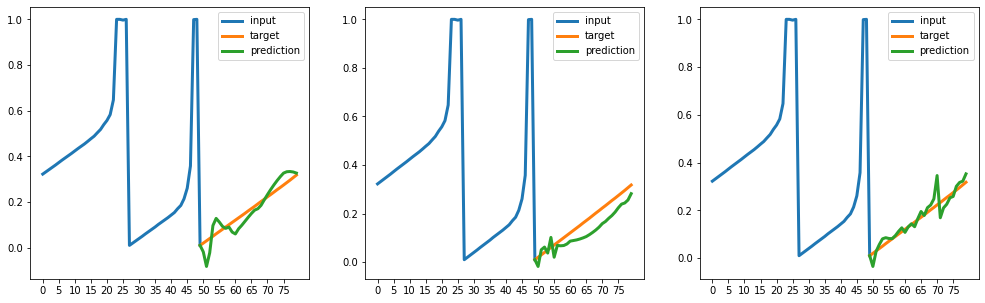

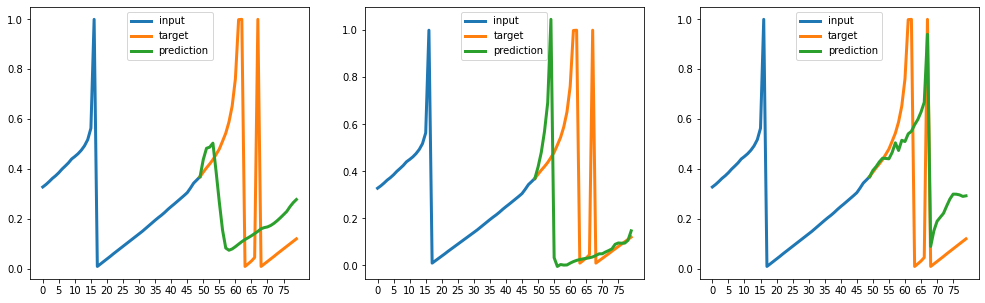

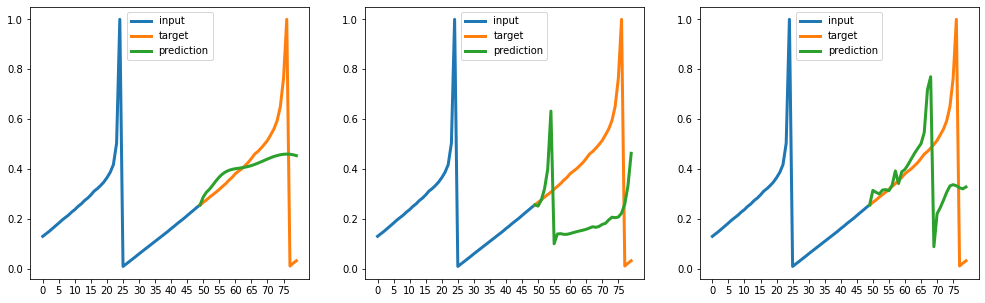

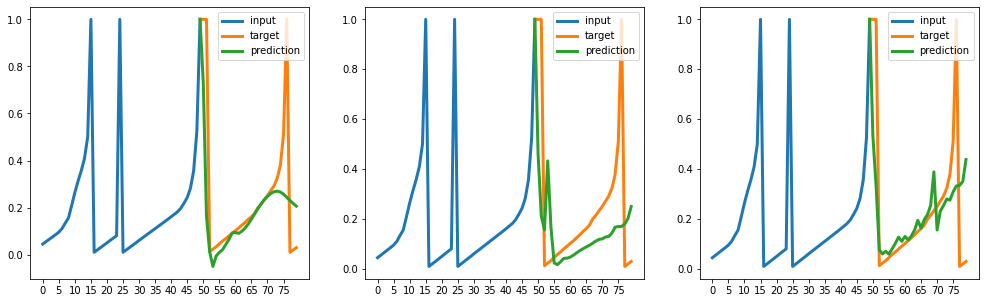

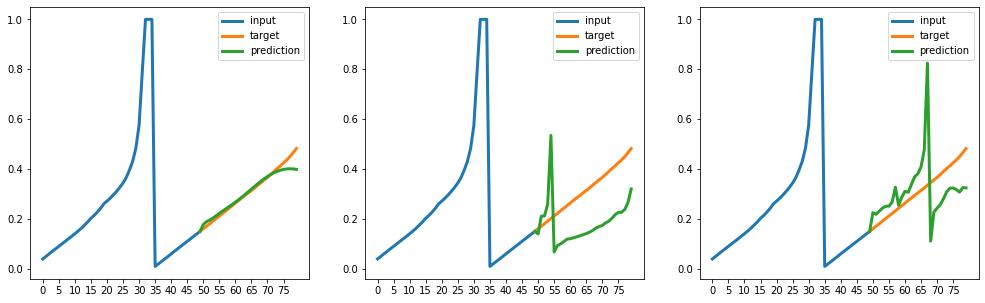

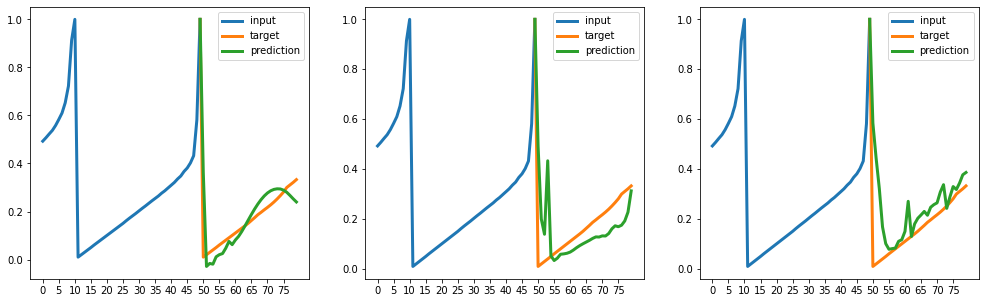

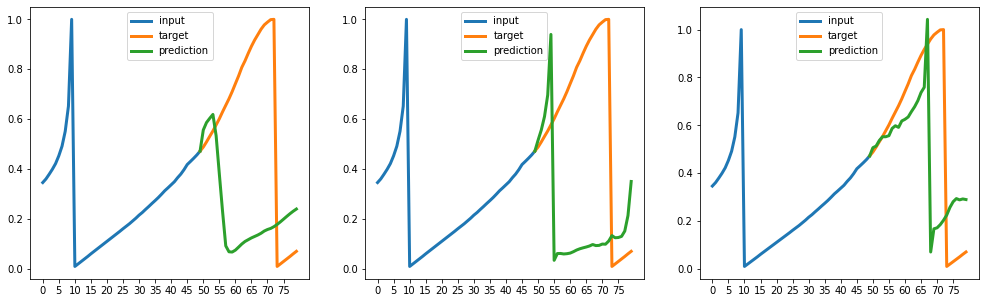

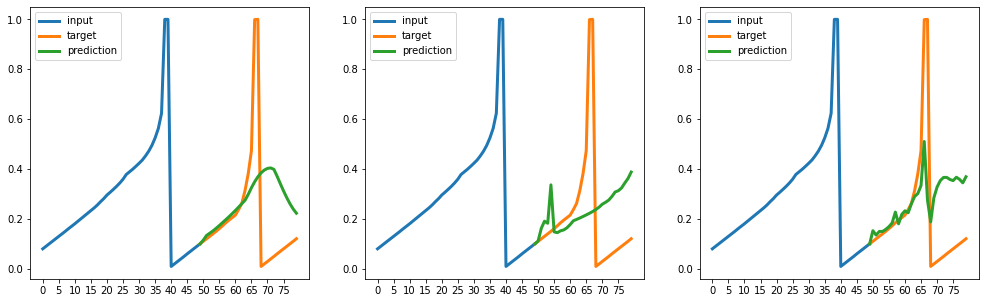

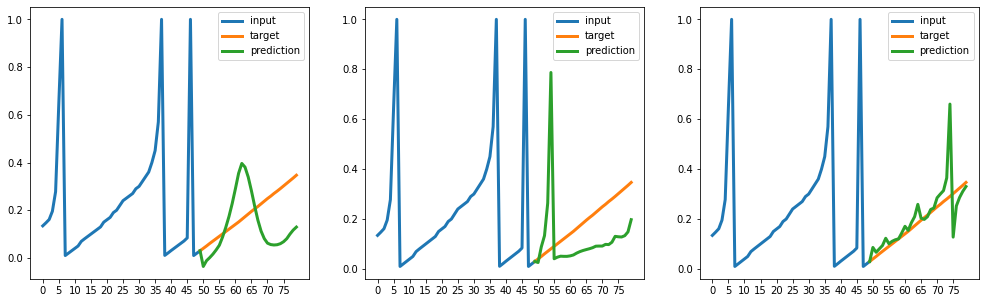

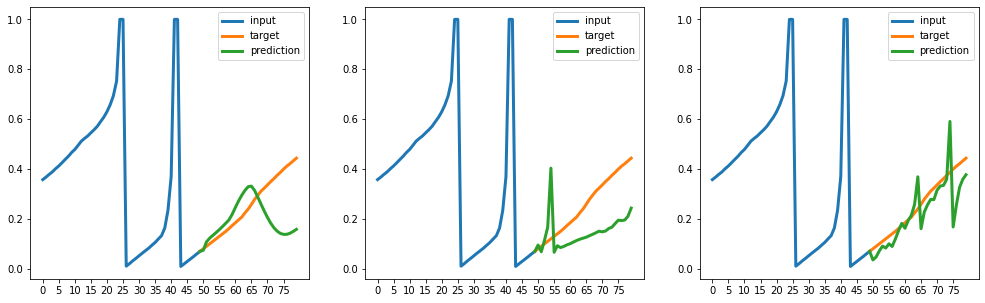

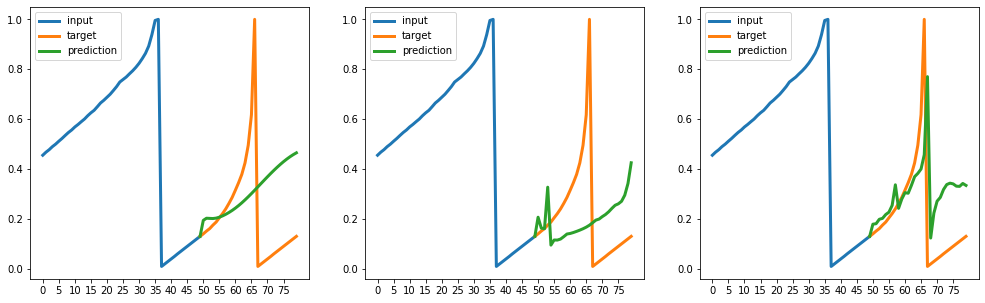

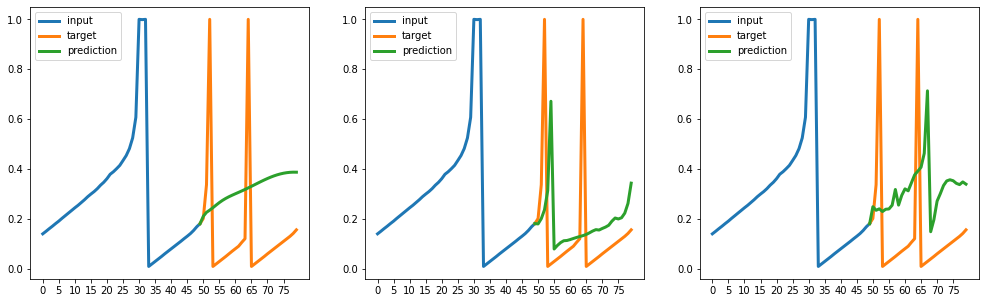

In [0]:
# Visualize results
gen_traffic_test = iter(trafficTestloader)
traffic_test_input, traffic_test_target = next(gen_traffic_test)

traffic_test_input  = torch.tensor(traffic_test_input, dtype=torch.float32).to(device)
traffic_test_target = torch.tensor(traffic_test_target, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse_2, net_gru_dtw_2, net_gru_dilate_2]

for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        traffic_pred = net(traffic_test_input).to(device)

        traffic_input = traffic_test_input.detach().cpu().numpy()[ind,:,:]
        traffic_target = traffic_test_target.detach().cpu().numpy()[ind,:,:]
        traffic_preds = traffic_pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0,InputNo) ,traffic_input,label='input',linewidth=3)
        plt.plot(range(InputNo-1,InputNo+OutputNo), np.concatenate([ traffic_input[InputNo-1:InputNo], traffic_target ]) ,label='target',linewidth=3)   
        plt.plot(range(InputNo-1,InputNo+OutputNo),  np.concatenate([ traffic_input[InputNo-1:InputNo], traffic_preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,80,5))
        plt.legend()
        k = k+1

    plt.show()


# Exploring the effect of Alpha


In [0]:
#setting up the network
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)

alpha=0 
for ind in range(11):
  train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=500, gamma=gamma, alpha=alpha, print_every=50, eval_every=50,verbose=0)
  eval_model(net_gru_dilate,testloader, gamma,verbose=1)
  alpha+=0.1


 Eval mse=  6.5466290473937985  dtw=  11.34155332325081  tdi=  0.0
 Eval mse=  0.04771271124482155  dtw=  0.9295638979502012  tdi=  0.101405
 Eval mse=  0.026124510541558267  dtw=  0.5876743252022825  tdi=  0.197355
 Eval mse=  0.015432096831500531  dtw=  0.25295372056450083  tdi=  1.051835
 Eval mse=  0.015177514962852  dtw=  0.22753645162856667  tdi=  1.2646000000000002
 Eval mse=  0.01322223898023367  dtw=  0.18626221729452547  tdi=  1.403215
 Eval mse=  0.013810134306550027  dtw=  0.17173280674760047  tdi=  1.687595
 Eval mse=  0.015292691811919213  dtw=  0.2108384580230004  tdi=  1.6683300000000003
 Eval mse=  0.013968151994049549  dtw=  0.14036837553711948  tdi=  1.4776950000000002
 Eval mse=  0.013727155700325965  dtw=  0.13425410793847914  tdi=  1.643225
 Eval mse=  0.01764087826013565  dtw=  0.13450526402299723  tdi=  1.8961999999999997
